In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Es un entorno sencillo que nos permite hacer pruebas rapidas con QLearning
env = gym.make('FrozenLake-v0')

In [3]:
tf.reset_default_graph()

In [4]:
#Si usamos una red neuronal para predecir el valor de un par (Estado,accion)

#Aquí no hay función de activación por lo que todo el modelo será lineal
#Para un caso simple como este basta, pero para casos mas complejos necesitaremos funciones de activacion como RELU o la sigmoide.
#La predicción será la acción que mayor Q tenga

inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))  #Los pesos serán los parámetros que modificará la NN
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

nextQ = tf.placeholder(shape = [1,4], dtype = tf.float32)
#al usar los errores cuadráticos les damos más importancia a los mayores y menos a las pequeñas desviaciones
loss = tf.reduce_sum(tf.square(nextQ - Qout))

trainer = tf.train.GradientDescentOptimizer(learning_rate = 0.1)
updateModel = trainer.minimize(loss)

In [5]:
init = tf.initializers.global_variables()

gamma = .99     #el discount factor, es decir, lo importante que son los rewards futuros para el valor Q
epsilon = .1    #el epsilon nos sirve para controlar el factor de exploración
num_episodes = 20000

episode_list = []      # la cantidad de pasos que tarda cada episodio
reward_list = []       #la lista de rewards de todos los episodios

with tf.Session() as sess:
    sess.run(init) #inicializamos la sesión y las variables globales
    for i in range(num_episodes):
        
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        
        while j < 99:  #99 es el numero maximo de pasos en un episodio
            j += 1
            
            #hacemos una ejecucion de la red neuronal con los datos del estado y sacamos las predicciones junto con la mejor accion
            a,allQ = sess.run([predict,Qout], feed_dict = {inputs1:np.identity(16)[s:s+1]})
            
            #aqui gestionamos la exploración con el parametro epsilon
            if np.random.rand(1) < epsilon:
                a[0] = env.action_space.sample()
                
            #hacemos un step con la acción elegida y recibimos la señal de recompensa del entorno
            s1,r,d,_ = env.step(a[0])
            
            #Recibimos las predicciones de los valores Q para el proximo estado
            Q1 = sess.run(Qout, feed_dict = {inputs1:np.identity(16)[s1:s1+1]})
            
            #obtenemos la mayor para s+1 para poder actualizar el valor de Q con el gamma por el maximo de s+1
            maxQ1 = np.max(Q1)
            
            targetQ = allQ
            #solo hay 1 elemento en la dim 0 y en la segunda son el valor q para cada accion
            #asi que acutalizamos el valor de targetq basandonos en eso
            targetQ[0,a[0]] = r + gamma*maxQ1
            
            #hacemos aqui la parte de backpropagation actualizando la funcion de coste dado el estado actual y como nextQ le pasamos el targetQ calculado
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                epsilon = 1./((i/50) + 10)
                break
        episode_list.append(j)
        reward_list.append(rAll)
        print("Average score per episode: " + str(sum(reward_list)/num_episodes) + " at iteration:" + str(i))
        

Average score per episode: 0.0 at iteration:0
Average score per episode: 0.0 at iteration:1
Average score per episode: 0.0 at iteration:2
Average score per episode: 0.0 at iteration:3
Average score per episode: 0.0 at iteration:4
Average score per episode: 0.0 at iteration:5
Average score per episode: 0.0 at iteration:6
Average score per episode: 0.0 at iteration:7
Average score per episode: 0.0 at iteration:8
Average score per episode: 0.0 at iteration:9
Average score per episode: 0.0 at iteration:10
Average score per episode: 0.0 at iteration:11
Average score per episode: 0.0 at iteration:12
Average score per episode: 0.0 at iteration:13
Average score per episode: 0.0 at iteration:14
Average score per episode: 0.0 at iteration:15
Average score per episode: 0.0 at iteration:16
Average score per episode: 0.0 at iteration:17
Average score per episode: 0.0 at iteration:18
Average score per episode: 0.0 at iteration:19
Average score per episode: 0.0 at iteration:20
Average score per episo

Average score per episode: 0.00015 at iteration:174
Average score per episode: 0.00015 at iteration:175
Average score per episode: 0.00015 at iteration:176
Average score per episode: 0.00015 at iteration:177
Average score per episode: 0.00015 at iteration:178
Average score per episode: 0.00015 at iteration:179
Average score per episode: 0.00015 at iteration:180
Average score per episode: 0.00015 at iteration:181
Average score per episode: 0.00015 at iteration:182
Average score per episode: 0.00015 at iteration:183
Average score per episode: 0.00015 at iteration:184
Average score per episode: 0.00015 at iteration:185
Average score per episode: 0.00015 at iteration:186
Average score per episode: 0.00015 at iteration:187
Average score per episode: 0.00015 at iteration:188
Average score per episode: 0.00015 at iteration:189
Average score per episode: 0.00015 at iteration:190
Average score per episode: 0.0002 at iteration:191
Average score per episode: 0.0002 at iteration:192
Average score 

Average score per episode: 0.0007 at iteration:338
Average score per episode: 0.0007 at iteration:339
Average score per episode: 0.0007 at iteration:340
Average score per episode: 0.0007 at iteration:341
Average score per episode: 0.0007 at iteration:342
Average score per episode: 0.0007 at iteration:343
Average score per episode: 0.0007 at iteration:344
Average score per episode: 0.0007 at iteration:345
Average score per episode: 0.0007 at iteration:346
Average score per episode: 0.0007 at iteration:347
Average score per episode: 0.0007 at iteration:348
Average score per episode: 0.0007 at iteration:349
Average score per episode: 0.0007 at iteration:350
Average score per episode: 0.0007 at iteration:351
Average score per episode: 0.0007 at iteration:352
Average score per episode: 0.0007 at iteration:353
Average score per episode: 0.0007 at iteration:354
Average score per episode: 0.0007 at iteration:355
Average score per episode: 0.0007 at iteration:356
Average score per episode: 0.00

Average score per episode: 0.0014 at iteration:500
Average score per episode: 0.0014 at iteration:501
Average score per episode: 0.0014 at iteration:502
Average score per episode: 0.00145 at iteration:503
Average score per episode: 0.00145 at iteration:504
Average score per episode: 0.00145 at iteration:505
Average score per episode: 0.00145 at iteration:506
Average score per episode: 0.00145 at iteration:507
Average score per episode: 0.00145 at iteration:508
Average score per episode: 0.00145 at iteration:509
Average score per episode: 0.00145 at iteration:510
Average score per episode: 0.00145 at iteration:511
Average score per episode: 0.00145 at iteration:512
Average score per episode: 0.00145 at iteration:513
Average score per episode: 0.00145 at iteration:514
Average score per episode: 0.00145 at iteration:515
Average score per episode: 0.00145 at iteration:516
Average score per episode: 0.00145 at iteration:517
Average score per episode: 0.00145 at iteration:518
Average score p

Average score per episode: 0.0023 at iteration:660
Average score per episode: 0.0023 at iteration:661
Average score per episode: 0.0023 at iteration:662
Average score per episode: 0.00235 at iteration:663
Average score per episode: 0.00235 at iteration:664
Average score per episode: 0.00235 at iteration:665
Average score per episode: 0.0024 at iteration:666
Average score per episode: 0.0024 at iteration:667
Average score per episode: 0.0024 at iteration:668
Average score per episode: 0.0024 at iteration:669
Average score per episode: 0.0024 at iteration:670
Average score per episode: 0.0024 at iteration:671
Average score per episode: 0.0024 at iteration:672
Average score per episode: 0.0024 at iteration:673
Average score per episode: 0.0024 at iteration:674
Average score per episode: 0.0024 at iteration:675
Average score per episode: 0.0024 at iteration:676
Average score per episode: 0.0024 at iteration:677
Average score per episode: 0.0024 at iteration:678
Average score per episode: 0

Average score per episode: 0.00275 at iteration:820
Average score per episode: 0.00275 at iteration:821
Average score per episode: 0.00275 at iteration:822
Average score per episode: 0.00275 at iteration:823
Average score per episode: 0.00275 at iteration:824
Average score per episode: 0.00275 at iteration:825
Average score per episode: 0.0028 at iteration:826
Average score per episode: 0.0028 at iteration:827
Average score per episode: 0.00285 at iteration:828
Average score per episode: 0.00285 at iteration:829
Average score per episode: 0.00285 at iteration:830
Average score per episode: 0.00285 at iteration:831
Average score per episode: 0.00285 at iteration:832
Average score per episode: 0.00285 at iteration:833
Average score per episode: 0.00285 at iteration:834
Average score per episode: 0.00285 at iteration:835
Average score per episode: 0.00285 at iteration:836
Average score per episode: 0.0029 at iteration:837
Average score per episode: 0.0029 at iteration:838
Average score pe

Average score per episode: 0.00385 at iteration:981
Average score per episode: 0.00385 at iteration:982
Average score per episode: 0.00385 at iteration:983
Average score per episode: 0.0039 at iteration:984
Average score per episode: 0.0039 at iteration:985
Average score per episode: 0.0039 at iteration:986
Average score per episode: 0.0039 at iteration:987
Average score per episode: 0.0039 at iteration:988
Average score per episode: 0.0039 at iteration:989
Average score per episode: 0.0039 at iteration:990
Average score per episode: 0.0039 at iteration:991
Average score per episode: 0.0039 at iteration:992
Average score per episode: 0.0039 at iteration:993
Average score per episode: 0.0039 at iteration:994
Average score per episode: 0.0039 at iteration:995
Average score per episode: 0.0039 at iteration:996
Average score per episode: 0.0039 at iteration:997
Average score per episode: 0.0039 at iteration:998
Average score per episode: 0.0039 at iteration:999
Average score per episode: 0

Average score per episode: 0.00435 at iteration:1140
Average score per episode: 0.00435 at iteration:1141
Average score per episode: 0.00435 at iteration:1142
Average score per episode: 0.00435 at iteration:1143
Average score per episode: 0.0044 at iteration:1144
Average score per episode: 0.0044 at iteration:1145
Average score per episode: 0.0044 at iteration:1146
Average score per episode: 0.0044 at iteration:1147
Average score per episode: 0.0044 at iteration:1148
Average score per episode: 0.0044 at iteration:1149
Average score per episode: 0.0044 at iteration:1150
Average score per episode: 0.0044 at iteration:1151
Average score per episode: 0.0044 at iteration:1152
Average score per episode: 0.0044 at iteration:1153
Average score per episode: 0.00445 at iteration:1154
Average score per episode: 0.00445 at iteration:1155
Average score per episode: 0.00445 at iteration:1156
Average score per episode: 0.00445 at iteration:1157
Average score per episode: 0.00445 at iteration:1158
Ave

Average score per episode: 0.0053 at iteration:1301
Average score per episode: 0.00535 at iteration:1302
Average score per episode: 0.00535 at iteration:1303
Average score per episode: 0.00535 at iteration:1304
Average score per episode: 0.00535 at iteration:1305
Average score per episode: 0.00535 at iteration:1306
Average score per episode: 0.0054 at iteration:1307
Average score per episode: 0.0054 at iteration:1308
Average score per episode: 0.0054 at iteration:1309
Average score per episode: 0.0054 at iteration:1310
Average score per episode: 0.00545 at iteration:1311
Average score per episode: 0.00545 at iteration:1312
Average score per episode: 0.00545 at iteration:1313
Average score per episode: 0.00545 at iteration:1314
Average score per episode: 0.00545 at iteration:1315
Average score per episode: 0.00545 at iteration:1316
Average score per episode: 0.0055 at iteration:1317
Average score per episode: 0.0055 at iteration:1318
Average score per episode: 0.0055 at iteration:1319
A

Average score per episode: 0.0066 at iteration:1459
Average score per episode: 0.0066 at iteration:1460
Average score per episode: 0.0066 at iteration:1461
Average score per episode: 0.00665 at iteration:1462
Average score per episode: 0.00665 at iteration:1463
Average score per episode: 0.00665 at iteration:1464
Average score per episode: 0.00665 at iteration:1465
Average score per episode: 0.00665 at iteration:1466
Average score per episode: 0.00665 at iteration:1467
Average score per episode: 0.00665 at iteration:1468
Average score per episode: 0.00665 at iteration:1469
Average score per episode: 0.00665 at iteration:1470
Average score per episode: 0.00665 at iteration:1471
Average score per episode: 0.00665 at iteration:1472
Average score per episode: 0.00665 at iteration:1473
Average score per episode: 0.00665 at iteration:1474
Average score per episode: 0.00665 at iteration:1475
Average score per episode: 0.0067 at iteration:1476
Average score per episode: 0.0067 at iteration:147

Average score per episode: 0.00755 at iteration:1618
Average score per episode: 0.0076 at iteration:1619
Average score per episode: 0.0076 at iteration:1620
Average score per episode: 0.0076 at iteration:1621
Average score per episode: 0.0076 at iteration:1622
Average score per episode: 0.0076 at iteration:1623
Average score per episode: 0.0076 at iteration:1624
Average score per episode: 0.0076 at iteration:1625
Average score per episode: 0.0076 at iteration:1626
Average score per episode: 0.0076 at iteration:1627
Average score per episode: 0.00765 at iteration:1628
Average score per episode: 0.00765 at iteration:1629
Average score per episode: 0.00765 at iteration:1630
Average score per episode: 0.00765 at iteration:1631
Average score per episode: 0.00765 at iteration:1632
Average score per episode: 0.0077 at iteration:1633
Average score per episode: 0.0077 at iteration:1634
Average score per episode: 0.0077 at iteration:1635
Average score per episode: 0.0077 at iteration:1636
Averag

Average score per episode: 0.0087 at iteration:1777
Average score per episode: 0.00875 at iteration:1778
Average score per episode: 0.00875 at iteration:1779
Average score per episode: 0.00875 at iteration:1780
Average score per episode: 0.00875 at iteration:1781
Average score per episode: 0.00875 at iteration:1782
Average score per episode: 0.00875 at iteration:1783
Average score per episode: 0.00875 at iteration:1784
Average score per episode: 0.00875 at iteration:1785
Average score per episode: 0.00875 at iteration:1786
Average score per episode: 0.00875 at iteration:1787
Average score per episode: 0.0088 at iteration:1788
Average score per episode: 0.0088 at iteration:1789
Average score per episode: 0.0088 at iteration:1790
Average score per episode: 0.0088 at iteration:1791
Average score per episode: 0.0088 at iteration:1792
Average score per episode: 0.0088 at iteration:1793
Average score per episode: 0.0088 at iteration:1794
Average score per episode: 0.0088 at iteration:1795
Av

Average score per episode: 0.0099 at iteration:1935
Average score per episode: 0.0099 at iteration:1936
Average score per episode: 0.0099 at iteration:1937
Average score per episode: 0.0099 at iteration:1938
Average score per episode: 0.0099 at iteration:1939
Average score per episode: 0.0099 at iteration:1940
Average score per episode: 0.0099 at iteration:1941
Average score per episode: 0.0099 at iteration:1942
Average score per episode: 0.0099 at iteration:1943
Average score per episode: 0.0099 at iteration:1944
Average score per episode: 0.0099 at iteration:1945
Average score per episode: 0.00995 at iteration:1946
Average score per episode: 0.00995 at iteration:1947
Average score per episode: 0.01 at iteration:1948
Average score per episode: 0.01 at iteration:1949
Average score per episode: 0.01 at iteration:1950
Average score per episode: 0.01005 at iteration:1951
Average score per episode: 0.01005 at iteration:1952
Average score per episode: 0.01005 at iteration:1953
Average score

Average score per episode: 0.01065 at iteration:2091
Average score per episode: 0.01065 at iteration:2092
Average score per episode: 0.0107 at iteration:2093
Average score per episode: 0.0107 at iteration:2094
Average score per episode: 0.0107 at iteration:2095
Average score per episode: 0.0107 at iteration:2096
Average score per episode: 0.0107 at iteration:2097
Average score per episode: 0.0107 at iteration:2098
Average score per episode: 0.0107 at iteration:2099
Average score per episode: 0.0107 at iteration:2100
Average score per episode: 0.0107 at iteration:2101
Average score per episode: 0.0107 at iteration:2102
Average score per episode: 0.0107 at iteration:2103
Average score per episode: 0.0107 at iteration:2104
Average score per episode: 0.0107 at iteration:2105
Average score per episode: 0.0107 at iteration:2106
Average score per episode: 0.0107 at iteration:2107
Average score per episode: 0.0107 at iteration:2108
Average score per episode: 0.0107 at iteration:2109
Average sc

Average score per episode: 0.01195 at iteration:2250
Average score per episode: 0.01195 at iteration:2251
Average score per episode: 0.01195 at iteration:2252
Average score per episode: 0.012 at iteration:2253
Average score per episode: 0.012 at iteration:2254
Average score per episode: 0.012 at iteration:2255
Average score per episode: 0.012 at iteration:2256
Average score per episode: 0.012 at iteration:2257
Average score per episode: 0.012 at iteration:2258
Average score per episode: 0.012 at iteration:2259
Average score per episode: 0.01205 at iteration:2260
Average score per episode: 0.01205 at iteration:2261
Average score per episode: 0.0121 at iteration:2262
Average score per episode: 0.0121 at iteration:2263
Average score per episode: 0.01215 at iteration:2264
Average score per episode: 0.01215 at iteration:2265
Average score per episode: 0.0122 at iteration:2266
Average score per episode: 0.0122 at iteration:2267
Average score per episode: 0.0122 at iteration:2268
Average scor

Average score per episode: 0.01345 at iteration:2413
Average score per episode: 0.01345 at iteration:2414
Average score per episode: 0.01345 at iteration:2415
Average score per episode: 0.01345 at iteration:2416
Average score per episode: 0.01345 at iteration:2417
Average score per episode: 0.01345 at iteration:2418
Average score per episode: 0.01345 at iteration:2419
Average score per episode: 0.01345 at iteration:2420
Average score per episode: 0.0135 at iteration:2421
Average score per episode: 0.0135 at iteration:2422
Average score per episode: 0.0135 at iteration:2423
Average score per episode: 0.0135 at iteration:2424
Average score per episode: 0.0135 at iteration:2425
Average score per episode: 0.0135 at iteration:2426
Average score per episode: 0.0135 at iteration:2427
Average score per episode: 0.0135 at iteration:2428
Average score per episode: 0.0135 at iteration:2429
Average score per episode: 0.0135 at iteration:2430
Average score per episode: 0.0135 at iteration:2431
Aver

Average score per episode: 0.01485 at iteration:2571
Average score per episode: 0.01485 at iteration:2572
Average score per episode: 0.01485 at iteration:2573
Average score per episode: 0.01485 at iteration:2574
Average score per episode: 0.01485 at iteration:2575
Average score per episode: 0.01485 at iteration:2576
Average score per episode: 0.01485 at iteration:2577
Average score per episode: 0.01485 at iteration:2578
Average score per episode: 0.01485 at iteration:2579
Average score per episode: 0.01485 at iteration:2580
Average score per episode: 0.01485 at iteration:2581
Average score per episode: 0.01485 at iteration:2582
Average score per episode: 0.01485 at iteration:2583
Average score per episode: 0.01485 at iteration:2584
Average score per episode: 0.01485 at iteration:2585
Average score per episode: 0.01485 at iteration:2586
Average score per episode: 0.01485 at iteration:2587
Average score per episode: 0.0149 at iteration:2588
Average score per episode: 0.0149 at iteration:

Average score per episode: 0.0169 at iteration:2728
Average score per episode: 0.01695 at iteration:2729
Average score per episode: 0.017 at iteration:2730
Average score per episode: 0.01705 at iteration:2731
Average score per episode: 0.01705 at iteration:2732
Average score per episode: 0.01705 at iteration:2733
Average score per episode: 0.01705 at iteration:2734
Average score per episode: 0.01705 at iteration:2735
Average score per episode: 0.01705 at iteration:2736
Average score per episode: 0.01705 at iteration:2737
Average score per episode: 0.01705 at iteration:2738
Average score per episode: 0.01705 at iteration:2739
Average score per episode: 0.0171 at iteration:2740
Average score per episode: 0.01715 at iteration:2741
Average score per episode: 0.01715 at iteration:2742
Average score per episode: 0.01715 at iteration:2743
Average score per episode: 0.0172 at iteration:2744
Average score per episode: 0.01725 at iteration:2745
Average score per episode: 0.0173 at iteration:2746

Average score per episode: 0.01935 at iteration:2887
Average score per episode: 0.01935 at iteration:2888
Average score per episode: 0.01935 at iteration:2889
Average score per episode: 0.0194 at iteration:2890
Average score per episode: 0.0194 at iteration:2891
Average score per episode: 0.0194 at iteration:2892
Average score per episode: 0.0194 at iteration:2893
Average score per episode: 0.0194 at iteration:2894
Average score per episode: 0.0194 at iteration:2895
Average score per episode: 0.0194 at iteration:2896
Average score per episode: 0.01945 at iteration:2897
Average score per episode: 0.0195 at iteration:2898
Average score per episode: 0.01955 at iteration:2899
Average score per episode: 0.0196 at iteration:2900
Average score per episode: 0.01965 at iteration:2901
Average score per episode: 0.01965 at iteration:2902
Average score per episode: 0.01965 at iteration:2903
Average score per episode: 0.01965 at iteration:2904
Average score per episode: 0.0197 at iteration:2905
Ave

Average score per episode: 0.02265 at iteration:3044
Average score per episode: 0.0227 at iteration:3045
Average score per episode: 0.02275 at iteration:3046
Average score per episode: 0.02275 at iteration:3047
Average score per episode: 0.02275 at iteration:3048
Average score per episode: 0.02275 at iteration:3049
Average score per episode: 0.02275 at iteration:3050
Average score per episode: 0.0228 at iteration:3051
Average score per episode: 0.02285 at iteration:3052
Average score per episode: 0.02285 at iteration:3053
Average score per episode: 0.0229 at iteration:3054
Average score per episode: 0.02295 at iteration:3055
Average score per episode: 0.023 at iteration:3056
Average score per episode: 0.023 at iteration:3057
Average score per episode: 0.023 at iteration:3058
Average score per episode: 0.023 at iteration:3059
Average score per episode: 0.023 at iteration:3060
Average score per episode: 0.023 at iteration:3061
Average score per episode: 0.023 at iteration:3062
Average sc

Average score per episode: 0.0276 at iteration:3201
Average score per episode: 0.02765 at iteration:3202
Average score per episode: 0.0277 at iteration:3203
Average score per episode: 0.02775 at iteration:3204
Average score per episode: 0.0278 at iteration:3205
Average score per episode: 0.02785 at iteration:3206
Average score per episode: 0.0279 at iteration:3207
Average score per episode: 0.02795 at iteration:3208
Average score per episode: 0.02795 at iteration:3209
Average score per episode: 0.02795 at iteration:3210
Average score per episode: 0.028 at iteration:3211
Average score per episode: 0.02805 at iteration:3212
Average score per episode: 0.02805 at iteration:3213
Average score per episode: 0.0281 at iteration:3214
Average score per episode: 0.02815 at iteration:3215
Average score per episode: 0.02815 at iteration:3216
Average score per episode: 0.02815 at iteration:3217
Average score per episode: 0.0282 at iteration:3218
Average score per episode: 0.02825 at iteration:3219
A

Average score per episode: 0.0329 at iteration:3360
Average score per episode: 0.03295 at iteration:3361
Average score per episode: 0.03295 at iteration:3362
Average score per episode: 0.03295 at iteration:3363
Average score per episode: 0.033 at iteration:3364
Average score per episode: 0.033 at iteration:3365
Average score per episode: 0.03305 at iteration:3366
Average score per episode: 0.0331 at iteration:3367
Average score per episode: 0.03315 at iteration:3368
Average score per episode: 0.03315 at iteration:3369
Average score per episode: 0.03315 at iteration:3370
Average score per episode: 0.0332 at iteration:3371
Average score per episode: 0.03325 at iteration:3372
Average score per episode: 0.03325 at iteration:3373
Average score per episode: 0.03325 at iteration:3374
Average score per episode: 0.0333 at iteration:3375
Average score per episode: 0.0333 at iteration:3376
Average score per episode: 0.0333 at iteration:3377
Average score per episode: 0.03335 at iteration:3378
Ave

Average score per episode: 0.0376 at iteration:3518
Average score per episode: 0.0376 at iteration:3519
Average score per episode: 0.03765 at iteration:3520
Average score per episode: 0.0377 at iteration:3521
Average score per episode: 0.03775 at iteration:3522
Average score per episode: 0.0378 at iteration:3523
Average score per episode: 0.03785 at iteration:3524
Average score per episode: 0.0379 at iteration:3525
Average score per episode: 0.03795 at iteration:3526
Average score per episode: 0.038 at iteration:3527
Average score per episode: 0.03805 at iteration:3528
Average score per episode: 0.0381 at iteration:3529
Average score per episode: 0.03815 at iteration:3530
Average score per episode: 0.0382 at iteration:3531
Average score per episode: 0.03825 at iteration:3532
Average score per episode: 0.0383 at iteration:3533
Average score per episode: 0.03835 at iteration:3534
Average score per episode: 0.0384 at iteration:3535
Average score per episode: 0.03845 at iteration:3536
Aver

Average score per episode: 0.0427 at iteration:3675
Average score per episode: 0.04275 at iteration:3676
Average score per episode: 0.0428 at iteration:3677
Average score per episode: 0.04285 at iteration:3678
Average score per episode: 0.04285 at iteration:3679
Average score per episode: 0.04285 at iteration:3680
Average score per episode: 0.0429 at iteration:3681
Average score per episode: 0.04295 at iteration:3682
Average score per episode: 0.043 at iteration:3683
Average score per episode: 0.04305 at iteration:3684
Average score per episode: 0.04305 at iteration:3685
Average score per episode: 0.0431 at iteration:3686
Average score per episode: 0.04315 at iteration:3687
Average score per episode: 0.04315 at iteration:3688
Average score per episode: 0.0432 at iteration:3689
Average score per episode: 0.04325 at iteration:3690
Average score per episode: 0.0433 at iteration:3691
Average score per episode: 0.0433 at iteration:3692
Average score per episode: 0.04335 at iteration:3693
Av

Average score per episode: 0.0484 at iteration:3832
Average score per episode: 0.04845 at iteration:3833
Average score per episode: 0.04845 at iteration:3834
Average score per episode: 0.0485 at iteration:3835
Average score per episode: 0.04855 at iteration:3836
Average score per episode: 0.0486 at iteration:3837
Average score per episode: 0.04865 at iteration:3838
Average score per episode: 0.0487 at iteration:3839
Average score per episode: 0.04875 at iteration:3840
Average score per episode: 0.0488 at iteration:3841
Average score per episode: 0.04885 at iteration:3842
Average score per episode: 0.0489 at iteration:3843
Average score per episode: 0.04895 at iteration:3844
Average score per episode: 0.049 at iteration:3845
Average score per episode: 0.04905 at iteration:3846
Average score per episode: 0.04905 at iteration:3847
Average score per episode: 0.0491 at iteration:3848
Average score per episode: 0.04915 at iteration:3849
Average score per episode: 0.04915 at iteration:3850
Av

Average score per episode: 0.0535 at iteration:3990
Average score per episode: 0.05355 at iteration:3991
Average score per episode: 0.0536 at iteration:3992
Average score per episode: 0.0536 at iteration:3993
Average score per episode: 0.05365 at iteration:3994
Average score per episode: 0.0537 at iteration:3995
Average score per episode: 0.0537 at iteration:3996
Average score per episode: 0.0537 at iteration:3997
Average score per episode: 0.05375 at iteration:3998
Average score per episode: 0.05375 at iteration:3999
Average score per episode: 0.0538 at iteration:4000
Average score per episode: 0.0538 at iteration:4001
Average score per episode: 0.0538 at iteration:4002
Average score per episode: 0.05385 at iteration:4003
Average score per episode: 0.0539 at iteration:4004
Average score per episode: 0.05395 at iteration:4005
Average score per episode: 0.05395 at iteration:4006
Average score per episode: 0.054 at iteration:4007
Average score per episode: 0.05405 at iteration:4008
Avera

Average score per episode: 0.05835 at iteration:4148
Average score per episode: 0.0584 at iteration:4149
Average score per episode: 0.0584 at iteration:4150
Average score per episode: 0.05845 at iteration:4151
Average score per episode: 0.0585 at iteration:4152
Average score per episode: 0.05855 at iteration:4153
Average score per episode: 0.05855 at iteration:4154
Average score per episode: 0.0586 at iteration:4155
Average score per episode: 0.05865 at iteration:4156
Average score per episode: 0.0587 at iteration:4157
Average score per episode: 0.05875 at iteration:4158
Average score per episode: 0.05875 at iteration:4159
Average score per episode: 0.05875 at iteration:4160
Average score per episode: 0.0588 at iteration:4161
Average score per episode: 0.05885 at iteration:4162
Average score per episode: 0.0589 at iteration:4163
Average score per episode: 0.0589 at iteration:4164
Average score per episode: 0.05895 at iteration:4165
Average score per episode: 0.059 at iteration:4166
Ave

Average score per episode: 0.0631 at iteration:4307
Average score per episode: 0.06315 at iteration:4308
Average score per episode: 0.0632 at iteration:4309
Average score per episode: 0.0632 at iteration:4310
Average score per episode: 0.0632 at iteration:4311
Average score per episode: 0.0632 at iteration:4312
Average score per episode: 0.0632 at iteration:4313
Average score per episode: 0.06325 at iteration:4314
Average score per episode: 0.0633 at iteration:4315
Average score per episode: 0.06335 at iteration:4316
Average score per episode: 0.06335 at iteration:4317
Average score per episode: 0.0634 at iteration:4318
Average score per episode: 0.0634 at iteration:4319
Average score per episode: 0.06345 at iteration:4320
Average score per episode: 0.0635 at iteration:4321
Average score per episode: 0.06355 at iteration:4322
Average score per episode: 0.06355 at iteration:4323
Average score per episode: 0.0636 at iteration:4324
Average score per episode: 0.0636 at iteration:4325
Avera

Average score per episode: 0.06815 at iteration:4465
Average score per episode: 0.06815 at iteration:4466
Average score per episode: 0.0682 at iteration:4467
Average score per episode: 0.06825 at iteration:4468
Average score per episode: 0.0683 at iteration:4469
Average score per episode: 0.06835 at iteration:4470
Average score per episode: 0.0684 at iteration:4471
Average score per episode: 0.06845 at iteration:4472
Average score per episode: 0.0685 at iteration:4473
Average score per episode: 0.0685 at iteration:4474
Average score per episode: 0.06855 at iteration:4475
Average score per episode: 0.0686 at iteration:4476
Average score per episode: 0.06865 at iteration:4477
Average score per episode: 0.0687 at iteration:4478
Average score per episode: 0.06875 at iteration:4479
Average score per episode: 0.0688 at iteration:4480
Average score per episode: 0.06885 at iteration:4481
Average score per episode: 0.06885 at iteration:4482
Average score per episode: 0.0689 at iteration:4483
Av

Average score per episode: 0.07345 at iteration:4622
Average score per episode: 0.07345 at iteration:4623
Average score per episode: 0.07345 at iteration:4624
Average score per episode: 0.0735 at iteration:4625
Average score per episode: 0.0735 at iteration:4626
Average score per episode: 0.0735 at iteration:4627
Average score per episode: 0.0735 at iteration:4628
Average score per episode: 0.07355 at iteration:4629
Average score per episode: 0.0736 at iteration:4630
Average score per episode: 0.07365 at iteration:4631
Average score per episode: 0.0737 at iteration:4632
Average score per episode: 0.07375 at iteration:4633
Average score per episode: 0.0738 at iteration:4634
Average score per episode: 0.07385 at iteration:4635
Average score per episode: 0.0739 at iteration:4636
Average score per episode: 0.0739 at iteration:4637
Average score per episode: 0.07395 at iteration:4638
Average score per episode: 0.074 at iteration:4639
Average score per episode: 0.074 at iteration:4640
Averag

Average score per episode: 0.0782 at iteration:4781
Average score per episode: 0.0782 at iteration:4782
Average score per episode: 0.07825 at iteration:4783
Average score per episode: 0.07825 at iteration:4784
Average score per episode: 0.0783 at iteration:4785
Average score per episode: 0.07835 at iteration:4786
Average score per episode: 0.0784 at iteration:4787
Average score per episode: 0.07845 at iteration:4788
Average score per episode: 0.0785 at iteration:4789
Average score per episode: 0.07855 at iteration:4790
Average score per episode: 0.07855 at iteration:4791
Average score per episode: 0.0786 at iteration:4792
Average score per episode: 0.07865 at iteration:4793
Average score per episode: 0.07865 at iteration:4794
Average score per episode: 0.0787 at iteration:4795
Average score per episode: 0.07875 at iteration:4796
Average score per episode: 0.07875 at iteration:4797
Average score per episode: 0.0788 at iteration:4798
Average score per episode: 0.07885 at iteration:4799
A

Average score per episode: 0.08355 at iteration:4939
Average score per episode: 0.08355 at iteration:4940
Average score per episode: 0.08355 at iteration:4941
Average score per episode: 0.08355 at iteration:4942
Average score per episode: 0.08355 at iteration:4943
Average score per episode: 0.0836 at iteration:4944
Average score per episode: 0.08365 at iteration:4945
Average score per episode: 0.0837 at iteration:4946
Average score per episode: 0.0837 at iteration:4947
Average score per episode: 0.0837 at iteration:4948
Average score per episode: 0.0837 at iteration:4949
Average score per episode: 0.0837 at iteration:4950
Average score per episode: 0.0837 at iteration:4951
Average score per episode: 0.0837 at iteration:4952
Average score per episode: 0.0837 at iteration:4953
Average score per episode: 0.08375 at iteration:4954
Average score per episode: 0.08375 at iteration:4955
Average score per episode: 0.08375 at iteration:4956
Average score per episode: 0.08375 at iteration:4957
Av

Average score per episode: 0.08725 at iteration:5099
Average score per episode: 0.08725 at iteration:5100
Average score per episode: 0.0873 at iteration:5101
Average score per episode: 0.08735 at iteration:5102
Average score per episode: 0.0874 at iteration:5103
Average score per episode: 0.08745 at iteration:5104
Average score per episode: 0.08745 at iteration:5105
Average score per episode: 0.08745 at iteration:5106
Average score per episode: 0.0875 at iteration:5107
Average score per episode: 0.08755 at iteration:5108
Average score per episode: 0.0876 at iteration:5109
Average score per episode: 0.08765 at iteration:5110
Average score per episode: 0.08765 at iteration:5111
Average score per episode: 0.08765 at iteration:5112
Average score per episode: 0.08765 at iteration:5113
Average score per episode: 0.08765 at iteration:5114
Average score per episode: 0.0877 at iteration:5115
Average score per episode: 0.0877 at iteration:5116
Average score per episode: 0.08775 at iteration:5117

Average score per episode: 0.092 at iteration:5258
Average score per episode: 0.09205 at iteration:5259
Average score per episode: 0.0921 at iteration:5260
Average score per episode: 0.0921 at iteration:5261
Average score per episode: 0.0921 at iteration:5262
Average score per episode: 0.0921 at iteration:5263
Average score per episode: 0.0921 at iteration:5264
Average score per episode: 0.09215 at iteration:5265
Average score per episode: 0.0922 at iteration:5266
Average score per episode: 0.09225 at iteration:5267
Average score per episode: 0.0923 at iteration:5268
Average score per episode: 0.09235 at iteration:5269
Average score per episode: 0.0924 at iteration:5270
Average score per episode: 0.09245 at iteration:5271
Average score per episode: 0.0925 at iteration:5272
Average score per episode: 0.0925 at iteration:5273
Average score per episode: 0.0925 at iteration:5274
Average score per episode: 0.0925 at iteration:5275
Average score per episode: 0.09255 at iteration:5276
Average

Average score per episode: 0.09685 at iteration:5415
Average score per episode: 0.0969 at iteration:5416
Average score per episode: 0.09695 at iteration:5417
Average score per episode: 0.097 at iteration:5418
Average score per episode: 0.09705 at iteration:5419
Average score per episode: 0.0971 at iteration:5420
Average score per episode: 0.09715 at iteration:5421
Average score per episode: 0.0972 at iteration:5422
Average score per episode: 0.0972 at iteration:5423
Average score per episode: 0.09725 at iteration:5424
Average score per episode: 0.0973 at iteration:5425
Average score per episode: 0.09735 at iteration:5426
Average score per episode: 0.0974 at iteration:5427
Average score per episode: 0.09745 at iteration:5428
Average score per episode: 0.0975 at iteration:5429
Average score per episode: 0.09755 at iteration:5430
Average score per episode: 0.0976 at iteration:5431
Average score per episode: 0.0976 at iteration:5432
Average score per episode: 0.0976 at iteration:5433
Avera

Average score per episode: 0.10195 at iteration:5572
Average score per episode: 0.10195 at iteration:5573
Average score per episode: 0.10195 at iteration:5574
Average score per episode: 0.102 at iteration:5575
Average score per episode: 0.10205 at iteration:5576
Average score per episode: 0.1021 at iteration:5577
Average score per episode: 0.1021 at iteration:5578
Average score per episode: 0.10215 at iteration:5579
Average score per episode: 0.10215 at iteration:5580
Average score per episode: 0.1022 at iteration:5581
Average score per episode: 0.10225 at iteration:5582
Average score per episode: 0.1023 at iteration:5583
Average score per episode: 0.1023 at iteration:5584
Average score per episode: 0.10235 at iteration:5585
Average score per episode: 0.1024 at iteration:5586
Average score per episode: 0.10245 at iteration:5587
Average score per episode: 0.1025 at iteration:5588
Average score per episode: 0.1025 at iteration:5589
Average score per episode: 0.1025 at iteration:5590
Aver

Average score per episode: 0.10715 at iteration:5730
Average score per episode: 0.1072 at iteration:5731
Average score per episode: 0.10725 at iteration:5732
Average score per episode: 0.1073 at iteration:5733
Average score per episode: 0.10735 at iteration:5734
Average score per episode: 0.1074 at iteration:5735
Average score per episode: 0.10745 at iteration:5736
Average score per episode: 0.1075 at iteration:5737
Average score per episode: 0.10755 at iteration:5738
Average score per episode: 0.1076 at iteration:5739
Average score per episode: 0.10765 at iteration:5740
Average score per episode: 0.1077 at iteration:5741
Average score per episode: 0.10775 at iteration:5742
Average score per episode: 0.1078 at iteration:5743
Average score per episode: 0.1078 at iteration:5744
Average score per episode: 0.10785 at iteration:5745
Average score per episode: 0.10785 at iteration:5746
Average score per episode: 0.1079 at iteration:5747
Average score per episode: 0.10795 at iteration:5748
Av

Average score per episode: 0.1126 at iteration:5889
Average score per episode: 0.1126 at iteration:5890
Average score per episode: 0.1126 at iteration:5891
Average score per episode: 0.11265 at iteration:5892
Average score per episode: 0.1127 at iteration:5893
Average score per episode: 0.11275 at iteration:5894
Average score per episode: 0.11275 at iteration:5895
Average score per episode: 0.11275 at iteration:5896
Average score per episode: 0.1128 at iteration:5897
Average score per episode: 0.1128 at iteration:5898
Average score per episode: 0.1128 at iteration:5899
Average score per episode: 0.11285 at iteration:5900
Average score per episode: 0.1129 at iteration:5901
Average score per episode: 0.1129 at iteration:5902
Average score per episode: 0.1129 at iteration:5903
Average score per episode: 0.1129 at iteration:5904
Average score per episode: 0.1129 at iteration:5905
Average score per episode: 0.11295 at iteration:5906
Average score per episode: 0.113 at iteration:5907
Average

Average score per episode: 0.11775 at iteration:6049
Average score per episode: 0.1178 at iteration:6050
Average score per episode: 0.11785 at iteration:6051
Average score per episode: 0.1179 at iteration:6052
Average score per episode: 0.11795 at iteration:6053
Average score per episode: 0.11795 at iteration:6054
Average score per episode: 0.118 at iteration:6055
Average score per episode: 0.11805 at iteration:6056
Average score per episode: 0.11805 at iteration:6057
Average score per episode: 0.1181 at iteration:6058
Average score per episode: 0.1181 at iteration:6059
Average score per episode: 0.11815 at iteration:6060
Average score per episode: 0.11815 at iteration:6061
Average score per episode: 0.1182 at iteration:6062
Average score per episode: 0.11825 at iteration:6063
Average score per episode: 0.1183 at iteration:6064
Average score per episode: 0.11835 at iteration:6065
Average score per episode: 0.1184 at iteration:6066
Average score per episode: 0.11845 at iteration:6067
Av

Average score per episode: 0.1233 at iteration:6209
Average score per episode: 0.1233 at iteration:6210
Average score per episode: 0.12335 at iteration:6211
Average score per episode: 0.1234 at iteration:6212
Average score per episode: 0.12345 at iteration:6213
Average score per episode: 0.1235 at iteration:6214
Average score per episode: 0.1235 at iteration:6215
Average score per episode: 0.12355 at iteration:6216
Average score per episode: 0.1236 at iteration:6217
Average score per episode: 0.1236 at iteration:6218
Average score per episode: 0.1236 at iteration:6219
Average score per episode: 0.12365 at iteration:6220
Average score per episode: 0.1237 at iteration:6221
Average score per episode: 0.12375 at iteration:6222
Average score per episode: 0.12375 at iteration:6223
Average score per episode: 0.1238 at iteration:6224
Average score per episode: 0.12385 at iteration:6225
Average score per episode: 0.1239 at iteration:6226
Average score per episode: 0.1239 at iteration:6227
Avera

Average score per episode: 0.1288 at iteration:6367
Average score per episode: 0.1288 at iteration:6368
Average score per episode: 0.12885 at iteration:6369
Average score per episode: 0.12885 at iteration:6370
Average score per episode: 0.12885 at iteration:6371
Average score per episode: 0.1289 at iteration:6372
Average score per episode: 0.1289 at iteration:6373
Average score per episode: 0.12895 at iteration:6374
Average score per episode: 0.129 at iteration:6375
Average score per episode: 0.12905 at iteration:6376
Average score per episode: 0.1291 at iteration:6377
Average score per episode: 0.12915 at iteration:6378
Average score per episode: 0.12915 at iteration:6379
Average score per episode: 0.12915 at iteration:6380
Average score per episode: 0.1292 at iteration:6381
Average score per episode: 0.12925 at iteration:6382
Average score per episode: 0.1293 at iteration:6383
Average score per episode: 0.12935 at iteration:6384
Average score per episode: 0.1294 at iteration:6385
Ave

Average score per episode: 0.134 at iteration:6524
Average score per episode: 0.13405 at iteration:6525
Average score per episode: 0.13405 at iteration:6526
Average score per episode: 0.1341 at iteration:6527
Average score per episode: 0.13415 at iteration:6528
Average score per episode: 0.1342 at iteration:6529
Average score per episode: 0.1342 at iteration:6530
Average score per episode: 0.13425 at iteration:6531
Average score per episode: 0.13425 at iteration:6532
Average score per episode: 0.1343 at iteration:6533
Average score per episode: 0.1343 at iteration:6534
Average score per episode: 0.13435 at iteration:6535
Average score per episode: 0.13435 at iteration:6536
Average score per episode: 0.1344 at iteration:6537
Average score per episode: 0.13445 at iteration:6538
Average score per episode: 0.1345 at iteration:6539
Average score per episode: 0.1345 at iteration:6540
Average score per episode: 0.13455 at iteration:6541
Average score per episode: 0.1346 at iteration:6542
Aver

Average score per episode: 0.1399 at iteration:6682
Average score per episode: 0.13995 at iteration:6683
Average score per episode: 0.14 at iteration:6684
Average score per episode: 0.14005 at iteration:6685
Average score per episode: 0.1401 at iteration:6686
Average score per episode: 0.14015 at iteration:6687
Average score per episode: 0.1402 at iteration:6688
Average score per episode: 0.14025 at iteration:6689
Average score per episode: 0.14025 at iteration:6690
Average score per episode: 0.1403 at iteration:6691
Average score per episode: 0.14035 at iteration:6692
Average score per episode: 0.1404 at iteration:6693
Average score per episode: 0.14045 at iteration:6694
Average score per episode: 0.1405 at iteration:6695
Average score per episode: 0.14055 at iteration:6696
Average score per episode: 0.1406 at iteration:6697
Average score per episode: 0.14065 at iteration:6698
Average score per episode: 0.1407 at iteration:6699
Average score per episode: 0.14075 at iteration:6700
Aver

Average score per episode: 0.14515 at iteration:6840
Average score per episode: 0.1452 at iteration:6841
Average score per episode: 0.1452 at iteration:6842
Average score per episode: 0.1452 at iteration:6843
Average score per episode: 0.14525 at iteration:6844
Average score per episode: 0.1453 at iteration:6845
Average score per episode: 0.14535 at iteration:6846
Average score per episode: 0.1454 at iteration:6847
Average score per episode: 0.14545 at iteration:6848
Average score per episode: 0.1455 at iteration:6849
Average score per episode: 0.14555 at iteration:6850
Average score per episode: 0.1456 at iteration:6851
Average score per episode: 0.14565 at iteration:6852
Average score per episode: 0.1457 at iteration:6853
Average score per episode: 0.14575 at iteration:6854
Average score per episode: 0.14575 at iteration:6855
Average score per episode: 0.1458 at iteration:6856
Average score per episode: 0.14585 at iteration:6857
Average score per episode: 0.1459 at iteration:6858
Ave

Average score per episode: 0.1503 at iteration:6998
Average score per episode: 0.15035 at iteration:6999
Average score per episode: 0.15035 at iteration:7000
Average score per episode: 0.15035 at iteration:7001
Average score per episode: 0.1504 at iteration:7002
Average score per episode: 0.1504 at iteration:7003
Average score per episode: 0.1504 at iteration:7004
Average score per episode: 0.1504 at iteration:7005
Average score per episode: 0.15045 at iteration:7006
Average score per episode: 0.1505 at iteration:7007
Average score per episode: 0.1505 at iteration:7008
Average score per episode: 0.15055 at iteration:7009
Average score per episode: 0.1506 at iteration:7010
Average score per episode: 0.1506 at iteration:7011
Average score per episode: 0.1506 at iteration:7012
Average score per episode: 0.15065 at iteration:7013
Average score per episode: 0.15065 at iteration:7014
Average score per episode: 0.1507 at iteration:7015
Average score per episode: 0.15075 at iteration:7016
Aver

Average score per episode: 0.15535 at iteration:7155
Average score per episode: 0.1554 at iteration:7156
Average score per episode: 0.15545 at iteration:7157
Average score per episode: 0.1555 at iteration:7158
Average score per episode: 0.15555 at iteration:7159
Average score per episode: 0.1556 at iteration:7160
Average score per episode: 0.1556 at iteration:7161
Average score per episode: 0.15565 at iteration:7162
Average score per episode: 0.15565 at iteration:7163
Average score per episode: 0.1557 at iteration:7164
Average score per episode: 0.15575 at iteration:7165
Average score per episode: 0.1558 at iteration:7166
Average score per episode: 0.1558 at iteration:7167
Average score per episode: 0.15585 at iteration:7168
Average score per episode: 0.1559 at iteration:7169
Average score per episode: 0.15595 at iteration:7170
Average score per episode: 0.15595 at iteration:7171
Average score per episode: 0.156 at iteration:7172
Average score per episode: 0.15605 at iteration:7173
Ave

Average score per episode: 0.16095 at iteration:7313
Average score per episode: 0.161 at iteration:7314
Average score per episode: 0.161 at iteration:7315
Average score per episode: 0.161 at iteration:7316
Average score per episode: 0.16105 at iteration:7317
Average score per episode: 0.1611 at iteration:7318
Average score per episode: 0.16115 at iteration:7319
Average score per episode: 0.1612 at iteration:7320
Average score per episode: 0.1612 at iteration:7321
Average score per episode: 0.16125 at iteration:7322
Average score per episode: 0.1613 at iteration:7323
Average score per episode: 0.16135 at iteration:7324
Average score per episode: 0.1614 at iteration:7325
Average score per episode: 0.16145 at iteration:7326
Average score per episode: 0.1615 at iteration:7327
Average score per episode: 0.16155 at iteration:7328
Average score per episode: 0.16155 at iteration:7329
Average score per episode: 0.1616 at iteration:7330
Average score per episode: 0.16165 at iteration:7331
Averag

Average score per episode: 0.16625 at iteration:7471
Average score per episode: 0.16625 at iteration:7472
Average score per episode: 0.1663 at iteration:7473
Average score per episode: 0.16635 at iteration:7474
Average score per episode: 0.1664 at iteration:7475
Average score per episode: 0.16645 at iteration:7476
Average score per episode: 0.1665 at iteration:7477
Average score per episode: 0.16655 at iteration:7478
Average score per episode: 0.1666 at iteration:7479
Average score per episode: 0.16665 at iteration:7480
Average score per episode: 0.16665 at iteration:7481
Average score per episode: 0.1667 at iteration:7482
Average score per episode: 0.16675 at iteration:7483
Average score per episode: 0.16675 at iteration:7484
Average score per episode: 0.1668 at iteration:7485
Average score per episode: 0.16685 at iteration:7486
Average score per episode: 0.1669 at iteration:7487
Average score per episode: 0.1669 at iteration:7488
Average score per episode: 0.16695 at iteration:7489
A

Average score per episode: 0.17165 at iteration:7628
Average score per episode: 0.17165 at iteration:7629
Average score per episode: 0.17165 at iteration:7630
Average score per episode: 0.1717 at iteration:7631
Average score per episode: 0.17175 at iteration:7632
Average score per episode: 0.17175 at iteration:7633
Average score per episode: 0.17175 at iteration:7634
Average score per episode: 0.17175 at iteration:7635
Average score per episode: 0.1718 at iteration:7636
Average score per episode: 0.17185 at iteration:7637
Average score per episode: 0.1719 at iteration:7638
Average score per episode: 0.17195 at iteration:7639
Average score per episode: 0.172 at iteration:7640
Average score per episode: 0.17205 at iteration:7641
Average score per episode: 0.1721 at iteration:7642
Average score per episode: 0.17215 at iteration:7643
Average score per episode: 0.1722 at iteration:7644
Average score per episode: 0.17225 at iteration:7645
Average score per episode: 0.1723 at iteration:7646
A

Average score per episode: 0.1772 at iteration:7785
Average score per episode: 0.17725 at iteration:7786
Average score per episode: 0.17725 at iteration:7787
Average score per episode: 0.17725 at iteration:7788
Average score per episode: 0.1773 at iteration:7789
Average score per episode: 0.1773 at iteration:7790
Average score per episode: 0.17735 at iteration:7791
Average score per episode: 0.17735 at iteration:7792
Average score per episode: 0.1774 at iteration:7793
Average score per episode: 0.17745 at iteration:7794
Average score per episode: 0.1775 at iteration:7795
Average score per episode: 0.1775 at iteration:7796
Average score per episode: 0.17755 at iteration:7797
Average score per episode: 0.17755 at iteration:7798
Average score per episode: 0.1776 at iteration:7799
Average score per episode: 0.17765 at iteration:7800
Average score per episode: 0.17765 at iteration:7801
Average score per episode: 0.1777 at iteration:7802
Average score per episode: 0.17775 at iteration:7803
A

Average score per episode: 0.183 at iteration:7944
Average score per episode: 0.18305 at iteration:7945
Average score per episode: 0.1831 at iteration:7946
Average score per episode: 0.18315 at iteration:7947
Average score per episode: 0.1832 at iteration:7948
Average score per episode: 0.18325 at iteration:7949
Average score per episode: 0.18325 at iteration:7950
Average score per episode: 0.1833 at iteration:7951
Average score per episode: 0.1833 at iteration:7952
Average score per episode: 0.1833 at iteration:7953
Average score per episode: 0.18335 at iteration:7954
Average score per episode: 0.1834 at iteration:7955
Average score per episode: 0.18345 at iteration:7956
Average score per episode: 0.18345 at iteration:7957
Average score per episode: 0.1835 at iteration:7958
Average score per episode: 0.1835 at iteration:7959
Average score per episode: 0.18355 at iteration:7960
Average score per episode: 0.1836 at iteration:7961
Average score per episode: 0.18365 at iteration:7962
Aver

Average score per episode: 0.1885 at iteration:8102
Average score per episode: 0.18855 at iteration:8103
Average score per episode: 0.1886 at iteration:8104
Average score per episode: 0.1886 at iteration:8105
Average score per episode: 0.18865 at iteration:8106
Average score per episode: 0.1887 at iteration:8107
Average score per episode: 0.1887 at iteration:8108
Average score per episode: 0.18875 at iteration:8109
Average score per episode: 0.18875 at iteration:8110
Average score per episode: 0.1888 at iteration:8111
Average score per episode: 0.18885 at iteration:8112
Average score per episode: 0.1889 at iteration:8113
Average score per episode: 0.18895 at iteration:8114
Average score per episode: 0.18895 at iteration:8115
Average score per episode: 0.18895 at iteration:8116
Average score per episode: 0.189 at iteration:8117
Average score per episode: 0.18905 at iteration:8118
Average score per episode: 0.18905 at iteration:8119
Average score per episode: 0.1891 at iteration:8120
Ave

Average score per episode: 0.1939 at iteration:8261
Average score per episode: 0.19395 at iteration:8262
Average score per episode: 0.194 at iteration:8263
Average score per episode: 0.19405 at iteration:8264
Average score per episode: 0.1941 at iteration:8265
Average score per episode: 0.1941 at iteration:8266
Average score per episode: 0.19415 at iteration:8267
Average score per episode: 0.1942 at iteration:8268
Average score per episode: 0.19425 at iteration:8269
Average score per episode: 0.1943 at iteration:8270
Average score per episode: 0.1943 at iteration:8271
Average score per episode: 0.1943 at iteration:8272
Average score per episode: 0.19435 at iteration:8273
Average score per episode: 0.1944 at iteration:8274
Average score per episode: 0.19445 at iteration:8275
Average score per episode: 0.1945 at iteration:8276
Average score per episode: 0.19455 at iteration:8277
Average score per episode: 0.1946 at iteration:8278
Average score per episode: 0.19465 at iteration:8279
Avera

Average score per episode: 0.1996 at iteration:8419
Average score per episode: 0.1996 at iteration:8420
Average score per episode: 0.1996 at iteration:8421
Average score per episode: 0.1996 at iteration:8422
Average score per episode: 0.19965 at iteration:8423
Average score per episode: 0.19965 at iteration:8424
Average score per episode: 0.1997 at iteration:8425
Average score per episode: 0.19975 at iteration:8426
Average score per episode: 0.19975 at iteration:8427
Average score per episode: 0.1998 at iteration:8428
Average score per episode: 0.1998 at iteration:8429
Average score per episode: 0.19985 at iteration:8430
Average score per episode: 0.1999 at iteration:8431
Average score per episode: 0.19995 at iteration:8432
Average score per episode: 0.19995 at iteration:8433
Average score per episode: 0.2 at iteration:8434
Average score per episode: 0.2 at iteration:8435
Average score per episode: 0.20005 at iteration:8436
Average score per episode: 0.20005 at iteration:8437
Average s

Average score per episode: 0.20525 at iteration:8576
Average score per episode: 0.2053 at iteration:8577
Average score per episode: 0.20535 at iteration:8578
Average score per episode: 0.2054 at iteration:8579
Average score per episode: 0.2054 at iteration:8580
Average score per episode: 0.20545 at iteration:8581
Average score per episode: 0.20545 at iteration:8582
Average score per episode: 0.2055 at iteration:8583
Average score per episode: 0.2055 at iteration:8584
Average score per episode: 0.20555 at iteration:8585
Average score per episode: 0.2056 at iteration:8586
Average score per episode: 0.20565 at iteration:8587
Average score per episode: 0.2057 at iteration:8588
Average score per episode: 0.20575 at iteration:8589
Average score per episode: 0.2058 at iteration:8590
Average score per episode: 0.20585 at iteration:8591
Average score per episode: 0.2059 at iteration:8592
Average score per episode: 0.20595 at iteration:8593
Average score per episode: 0.206 at iteration:8594
Aver

Average score per episode: 0.21145 at iteration:8733
Average score per episode: 0.2115 at iteration:8734
Average score per episode: 0.21155 at iteration:8735
Average score per episode: 0.2116 at iteration:8736
Average score per episode: 0.21165 at iteration:8737
Average score per episode: 0.2117 at iteration:8738
Average score per episode: 0.2117 at iteration:8739
Average score per episode: 0.21175 at iteration:8740
Average score per episode: 0.21175 at iteration:8741
Average score per episode: 0.21175 at iteration:8742
Average score per episode: 0.2118 at iteration:8743
Average score per episode: 0.2118 at iteration:8744
Average score per episode: 0.21185 at iteration:8745
Average score per episode: 0.2119 at iteration:8746
Average score per episode: 0.2119 at iteration:8747
Average score per episode: 0.21195 at iteration:8748
Average score per episode: 0.212 at iteration:8749
Average score per episode: 0.21205 at iteration:8750
Average score per episode: 0.2121 at iteration:8751
Aver

Average score per episode: 0.217 at iteration:8893
Average score per episode: 0.21705 at iteration:8894
Average score per episode: 0.2171 at iteration:8895
Average score per episode: 0.21715 at iteration:8896
Average score per episode: 0.21715 at iteration:8897
Average score per episode: 0.2172 at iteration:8898
Average score per episode: 0.21725 at iteration:8899
Average score per episode: 0.21725 at iteration:8900
Average score per episode: 0.2173 at iteration:8901
Average score per episode: 0.2173 at iteration:8902
Average score per episode: 0.21735 at iteration:8903
Average score per episode: 0.2174 at iteration:8904
Average score per episode: 0.21745 at iteration:8905
Average score per episode: 0.2175 at iteration:8906
Average score per episode: 0.21755 at iteration:8907
Average score per episode: 0.2176 at iteration:8908
Average score per episode: 0.21765 at iteration:8909
Average score per episode: 0.2177 at iteration:8910
Average score per episode: 0.2177 at iteration:8911
Aver

Average score per episode: 0.22205 at iteration:9051
Average score per episode: 0.2221 at iteration:9052
Average score per episode: 0.22215 at iteration:9053
Average score per episode: 0.2222 at iteration:9054
Average score per episode: 0.22225 at iteration:9055
Average score per episode: 0.2223 at iteration:9056
Average score per episode: 0.22235 at iteration:9057
Average score per episode: 0.2224 at iteration:9058
Average score per episode: 0.22245 at iteration:9059
Average score per episode: 0.2225 at iteration:9060
Average score per episode: 0.22255 at iteration:9061
Average score per episode: 0.2226 at iteration:9062
Average score per episode: 0.22265 at iteration:9063
Average score per episode: 0.22265 at iteration:9064
Average score per episode: 0.22265 at iteration:9065
Average score per episode: 0.22265 at iteration:9066
Average score per episode: 0.2227 at iteration:9067
Average score per episode: 0.22275 at iteration:9068
Average score per episode: 0.2228 at iteration:9069
A

Average score per episode: 0.2279 at iteration:9208
Average score per episode: 0.2279 at iteration:9209
Average score per episode: 0.22795 at iteration:9210
Average score per episode: 0.22795 at iteration:9211
Average score per episode: 0.228 at iteration:9212
Average score per episode: 0.228 at iteration:9213
Average score per episode: 0.228 at iteration:9214
Average score per episode: 0.22805 at iteration:9215
Average score per episode: 0.2281 at iteration:9216
Average score per episode: 0.22815 at iteration:9217
Average score per episode: 0.22815 at iteration:9218
Average score per episode: 0.2282 at iteration:9219
Average score per episode: 0.22825 at iteration:9220
Average score per episode: 0.2283 at iteration:9221
Average score per episode: 0.22835 at iteration:9222
Average score per episode: 0.2284 at iteration:9223
Average score per episode: 0.22845 at iteration:9224
Average score per episode: 0.22845 at iteration:9225
Average score per episode: 0.2285 at iteration:9226
Averag

Average score per episode: 0.23345 at iteration:9368
Average score per episode: 0.23345 at iteration:9369
Average score per episode: 0.2335 at iteration:9370
Average score per episode: 0.2335 at iteration:9371
Average score per episode: 0.2335 at iteration:9372
Average score per episode: 0.23355 at iteration:9373
Average score per episode: 0.23355 at iteration:9374
Average score per episode: 0.2336 at iteration:9375
Average score per episode: 0.2336 at iteration:9376
Average score per episode: 0.23365 at iteration:9377
Average score per episode: 0.2337 at iteration:9378
Average score per episode: 0.23375 at iteration:9379
Average score per episode: 0.23375 at iteration:9380
Average score per episode: 0.23375 at iteration:9381
Average score per episode: 0.2338 at iteration:9382
Average score per episode: 0.23385 at iteration:9383
Average score per episode: 0.2339 at iteration:9384
Average score per episode: 0.23395 at iteration:9385
Average score per episode: 0.234 at iteration:9386
Ave

Average score per episode: 0.2392 at iteration:9526
Average score per episode: 0.23925 at iteration:9527
Average score per episode: 0.2393 at iteration:9528
Average score per episode: 0.23935 at iteration:9529
Average score per episode: 0.2394 at iteration:9530
Average score per episode: 0.23945 at iteration:9531
Average score per episode: 0.2395 at iteration:9532
Average score per episode: 0.23955 at iteration:9533
Average score per episode: 0.23955 at iteration:9534
Average score per episode: 0.2396 at iteration:9535
Average score per episode: 0.2396 at iteration:9536
Average score per episode: 0.23965 at iteration:9537
Average score per episode: 0.23965 at iteration:9538
Average score per episode: 0.23965 at iteration:9539
Average score per episode: 0.2397 at iteration:9540
Average score per episode: 0.2397 at iteration:9541
Average score per episode: 0.2397 at iteration:9542
Average score per episode: 0.23975 at iteration:9543
Average score per episode: 0.23975 at iteration:9544
Av

Average score per episode: 0.24455 at iteration:9683
Average score per episode: 0.2446 at iteration:9684
Average score per episode: 0.24465 at iteration:9685
Average score per episode: 0.24465 at iteration:9686
Average score per episode: 0.2447 at iteration:9687
Average score per episode: 0.24475 at iteration:9688
Average score per episode: 0.2448 at iteration:9689
Average score per episode: 0.24485 at iteration:9690
Average score per episode: 0.24485 at iteration:9691
Average score per episode: 0.2449 at iteration:9692
Average score per episode: 0.24495 at iteration:9693
Average score per episode: 0.245 at iteration:9694
Average score per episode: 0.24505 at iteration:9695
Average score per episode: 0.24505 at iteration:9696
Average score per episode: 0.24505 at iteration:9697
Average score per episode: 0.2451 at iteration:9698
Average score per episode: 0.24515 at iteration:9699
Average score per episode: 0.2452 at iteration:9700
Average score per episode: 0.24525 at iteration:9701
A

Average score per episode: 0.2504 at iteration:9840
Average score per episode: 0.2504 at iteration:9841
Average score per episode: 0.25045 at iteration:9842
Average score per episode: 0.2505 at iteration:9843
Average score per episode: 0.2505 at iteration:9844
Average score per episode: 0.2505 at iteration:9845
Average score per episode: 0.25055 at iteration:9846
Average score per episode: 0.25055 at iteration:9847
Average score per episode: 0.2506 at iteration:9848
Average score per episode: 0.25065 at iteration:9849
Average score per episode: 0.2507 at iteration:9850
Average score per episode: 0.25075 at iteration:9851
Average score per episode: 0.2508 at iteration:9852
Average score per episode: 0.25085 at iteration:9853
Average score per episode: 0.2509 at iteration:9854
Average score per episode: 0.2509 at iteration:9855
Average score per episode: 0.25095 at iteration:9856
Average score per episode: 0.251 at iteration:9857
Average score per episode: 0.25105 at iteration:9858
Avera

Average score per episode: 0.2558 at iteration:9998
Average score per episode: 0.2558 at iteration:9999
Average score per episode: 0.2558 at iteration:10000
Average score per episode: 0.25585 at iteration:10001
Average score per episode: 0.2559 at iteration:10002
Average score per episode: 0.2559 at iteration:10003
Average score per episode: 0.25595 at iteration:10004
Average score per episode: 0.256 at iteration:10005
Average score per episode: 0.256 at iteration:10006
Average score per episode: 0.256 at iteration:10007
Average score per episode: 0.256 at iteration:10008
Average score per episode: 0.256 at iteration:10009
Average score per episode: 0.256 at iteration:10010
Average score per episode: 0.25605 at iteration:10011
Average score per episode: 0.25605 at iteration:10012
Average score per episode: 0.2561 at iteration:10013
Average score per episode: 0.2561 at iteration:10014
Average score per episode: 0.2561 at iteration:10015
Average score per episode: 0.25615 at iteration:10

Average score per episode: 0.2611 at iteration:10155
Average score per episode: 0.26115 at iteration:10156
Average score per episode: 0.2612 at iteration:10157
Average score per episode: 0.26125 at iteration:10158
Average score per episode: 0.2613 at iteration:10159
Average score per episode: 0.26135 at iteration:10160
Average score per episode: 0.2614 at iteration:10161
Average score per episode: 0.26145 at iteration:10162
Average score per episode: 0.2615 at iteration:10163
Average score per episode: 0.26155 at iteration:10164
Average score per episode: 0.2616 at iteration:10165
Average score per episode: 0.26165 at iteration:10166
Average score per episode: 0.26165 at iteration:10167
Average score per episode: 0.2617 at iteration:10168
Average score per episode: 0.2617 at iteration:10169
Average score per episode: 0.2617 at iteration:10170
Average score per episode: 0.2617 at iteration:10171
Average score per episode: 0.26175 at iteration:10172
Average score per episode: 0.2618 at i

Average score per episode: 0.2663 at iteration:10311
Average score per episode: 0.26635 at iteration:10312
Average score per episode: 0.26635 at iteration:10313
Average score per episode: 0.2664 at iteration:10314
Average score per episode: 0.2664 at iteration:10315
Average score per episode: 0.2664 at iteration:10316
Average score per episode: 0.26645 at iteration:10317
Average score per episode: 0.26645 at iteration:10318
Average score per episode: 0.26645 at iteration:10319
Average score per episode: 0.2665 at iteration:10320
Average score per episode: 0.2665 at iteration:10321
Average score per episode: 0.26655 at iteration:10322
Average score per episode: 0.26655 at iteration:10323
Average score per episode: 0.2666 at iteration:10324
Average score per episode: 0.26665 at iteration:10325
Average score per episode: 0.2667 at iteration:10326
Average score per episode: 0.26675 at iteration:10327
Average score per episode: 0.2668 at iteration:10328
Average score per episode: 0.26685 at

Average score per episode: 0.2716 at iteration:10465
Average score per episode: 0.27165 at iteration:10466
Average score per episode: 0.2717 at iteration:10467
Average score per episode: 0.27175 at iteration:10468
Average score per episode: 0.27175 at iteration:10469
Average score per episode: 0.2718 at iteration:10470
Average score per episode: 0.2718 at iteration:10471
Average score per episode: 0.2718 at iteration:10472
Average score per episode: 0.2718 at iteration:10473
Average score per episode: 0.27185 at iteration:10474
Average score per episode: 0.27185 at iteration:10475
Average score per episode: 0.2719 at iteration:10476
Average score per episode: 0.27195 at iteration:10477
Average score per episode: 0.272 at iteration:10478
Average score per episode: 0.27205 at iteration:10479
Average score per episode: 0.2721 at iteration:10480
Average score per episode: 0.2721 at iteration:10481
Average score per episode: 0.27215 at iteration:10482
Average score per episode: 0.27215 at i

Average score per episode: 0.27675 at iteration:10620
Average score per episode: 0.2768 at iteration:10621
Average score per episode: 0.2768 at iteration:10622
Average score per episode: 0.27685 at iteration:10623
Average score per episode: 0.27685 at iteration:10624
Average score per episode: 0.27685 at iteration:10625
Average score per episode: 0.2769 at iteration:10626
Average score per episode: 0.27695 at iteration:10627
Average score per episode: 0.277 at iteration:10628
Average score per episode: 0.277 at iteration:10629
Average score per episode: 0.27705 at iteration:10630
Average score per episode: 0.27705 at iteration:10631
Average score per episode: 0.2771 at iteration:10632
Average score per episode: 0.2771 at iteration:10633
Average score per episode: 0.27715 at iteration:10634
Average score per episode: 0.2772 at iteration:10635
Average score per episode: 0.27725 at iteration:10636
Average score per episode: 0.2773 at iteration:10637
Average score per episode: 0.2773 at it

Average score per episode: 0.2824 at iteration:10777
Average score per episode: 0.2824 at iteration:10778
Average score per episode: 0.28245 at iteration:10779
Average score per episode: 0.2825 at iteration:10780
Average score per episode: 0.28255 at iteration:10781
Average score per episode: 0.2826 at iteration:10782
Average score per episode: 0.28265 at iteration:10783
Average score per episode: 0.2827 at iteration:10784
Average score per episode: 0.28275 at iteration:10785
Average score per episode: 0.2828 at iteration:10786
Average score per episode: 0.28285 at iteration:10787
Average score per episode: 0.2829 at iteration:10788
Average score per episode: 0.28295 at iteration:10789
Average score per episode: 0.283 at iteration:10790
Average score per episode: 0.28305 at iteration:10791
Average score per episode: 0.28305 at iteration:10792
Average score per episode: 0.28305 at iteration:10793
Average score per episode: 0.2831 at iteration:10794
Average score per episode: 0.28315 at 

Average score per episode: 0.2881 at iteration:10933
Average score per episode: 0.28815 at iteration:10934
Average score per episode: 0.2882 at iteration:10935
Average score per episode: 0.28825 at iteration:10936
Average score per episode: 0.2883 at iteration:10937
Average score per episode: 0.28835 at iteration:10938
Average score per episode: 0.28835 at iteration:10939
Average score per episode: 0.28835 at iteration:10940
Average score per episode: 0.2884 at iteration:10941
Average score per episode: 0.28845 at iteration:10942
Average score per episode: 0.2885 at iteration:10943
Average score per episode: 0.2885 at iteration:10944
Average score per episode: 0.2885 at iteration:10945
Average score per episode: 0.28855 at iteration:10946
Average score per episode: 0.2886 at iteration:10947
Average score per episode: 0.28865 at iteration:10948
Average score per episode: 0.28865 at iteration:10949
Average score per episode: 0.2887 at iteration:10950
Average score per episode: 0.28875 at

Average score per episode: 0.2938 at iteration:11088
Average score per episode: 0.29385 at iteration:11089
Average score per episode: 0.2939 at iteration:11090
Average score per episode: 0.2939 at iteration:11091
Average score per episode: 0.29395 at iteration:11092
Average score per episode: 0.294 at iteration:11093
Average score per episode: 0.29405 at iteration:11094
Average score per episode: 0.2941 at iteration:11095
Average score per episode: 0.29415 at iteration:11096
Average score per episode: 0.2942 at iteration:11097
Average score per episode: 0.29425 at iteration:11098
Average score per episode: 0.2943 at iteration:11099
Average score per episode: 0.29435 at iteration:11100
Average score per episode: 0.2944 at iteration:11101
Average score per episode: 0.2944 at iteration:11102
Average score per episode: 0.29445 at iteration:11103
Average score per episode: 0.2945 at iteration:11104
Average score per episode: 0.2945 at iteration:11105
Average score per episode: 0.29455 at it

Average score per episode: 0.2999 at iteration:11242
Average score per episode: 0.2999 at iteration:11243
Average score per episode: 0.29995 at iteration:11244
Average score per episode: 0.29995 at iteration:11245
Average score per episode: 0.29995 at iteration:11246
Average score per episode: 0.3 at iteration:11247
Average score per episode: 0.30005 at iteration:11248
Average score per episode: 0.3001 at iteration:11249
Average score per episode: 0.30015 at iteration:11250
Average score per episode: 0.3002 at iteration:11251
Average score per episode: 0.30025 at iteration:11252
Average score per episode: 0.3003 at iteration:11253
Average score per episode: 0.3003 at iteration:11254
Average score per episode: 0.30035 at iteration:11255
Average score per episode: 0.30035 at iteration:11256
Average score per episode: 0.3004 at iteration:11257
Average score per episode: 0.30045 at iteration:11258
Average score per episode: 0.3005 at iteration:11259
Average score per episode: 0.30055 at it

Average score per episode: 0.3048 at iteration:11397
Average score per episode: 0.3048 at iteration:11398
Average score per episode: 0.30485 at iteration:11399
Average score per episode: 0.3049 at iteration:11400
Average score per episode: 0.30495 at iteration:11401
Average score per episode: 0.305 at iteration:11402
Average score per episode: 0.30505 at iteration:11403
Average score per episode: 0.30505 at iteration:11404
Average score per episode: 0.3051 at iteration:11405
Average score per episode: 0.30515 at iteration:11406
Average score per episode: 0.3052 at iteration:11407
Average score per episode: 0.30525 at iteration:11408
Average score per episode: 0.3053 at iteration:11409
Average score per episode: 0.30535 at iteration:11410
Average score per episode: 0.3054 at iteration:11411
Average score per episode: 0.3054 at iteration:11412
Average score per episode: 0.30545 at iteration:11413
Average score per episode: 0.3055 at iteration:11414
Average score per episode: 0.3055 at it

Average score per episode: 0.31045 at iteration:11553
Average score per episode: 0.3105 at iteration:11554
Average score per episode: 0.3105 at iteration:11555
Average score per episode: 0.3105 at iteration:11556
Average score per episode: 0.3105 at iteration:11557
Average score per episode: 0.31055 at iteration:11558
Average score per episode: 0.3106 at iteration:11559
Average score per episode: 0.31065 at iteration:11560
Average score per episode: 0.31065 at iteration:11561
Average score per episode: 0.3107 at iteration:11562
Average score per episode: 0.31075 at iteration:11563
Average score per episode: 0.3108 at iteration:11564
Average score per episode: 0.31085 at iteration:11565
Average score per episode: 0.3109 at iteration:11566
Average score per episode: 0.31095 at iteration:11567
Average score per episode: 0.311 at iteration:11568
Average score per episode: 0.311 at iteration:11569
Average score per episode: 0.31105 at iteration:11570
Average score per episode: 0.31105 at it

Average score per episode: 0.3156 at iteration:11708
Average score per episode: 0.3156 at iteration:11709
Average score per episode: 0.31565 at iteration:11710
Average score per episode: 0.3157 at iteration:11711
Average score per episode: 0.31575 at iteration:11712
Average score per episode: 0.31575 at iteration:11713
Average score per episode: 0.31575 at iteration:11714
Average score per episode: 0.31575 at iteration:11715
Average score per episode: 0.3158 at iteration:11716
Average score per episode: 0.31585 at iteration:11717
Average score per episode: 0.31585 at iteration:11718
Average score per episode: 0.3159 at iteration:11719
Average score per episode: 0.31595 at iteration:11720
Average score per episode: 0.316 at iteration:11721
Average score per episode: 0.316 at iteration:11722
Average score per episode: 0.31605 at iteration:11723
Average score per episode: 0.3161 at iteration:11724
Average score per episode: 0.31615 at iteration:11725
Average score per episode: 0.31615 at 

Average score per episode: 0.32015 at iteration:11864
Average score per episode: 0.3202 at iteration:11865
Average score per episode: 0.3202 at iteration:11866
Average score per episode: 0.32025 at iteration:11867
Average score per episode: 0.3203 at iteration:11868
Average score per episode: 0.3203 at iteration:11869
Average score per episode: 0.32035 at iteration:11870
Average score per episode: 0.3204 at iteration:11871
Average score per episode: 0.32045 at iteration:11872
Average score per episode: 0.32045 at iteration:11873
Average score per episode: 0.32045 at iteration:11874
Average score per episode: 0.3205 at iteration:11875
Average score per episode: 0.32055 at iteration:11876
Average score per episode: 0.3206 at iteration:11877
Average score per episode: 0.32065 at iteration:11878
Average score per episode: 0.3207 at iteration:11879
Average score per episode: 0.32075 at iteration:11880
Average score per episode: 0.3208 at iteration:11881
Average score per episode: 0.3208 at 

Average score per episode: 0.3253 at iteration:12020
Average score per episode: 0.32535 at iteration:12021
Average score per episode: 0.3254 at iteration:12022
Average score per episode: 0.3254 at iteration:12023
Average score per episode: 0.3254 at iteration:12024
Average score per episode: 0.32545 at iteration:12025
Average score per episode: 0.3255 at iteration:12026
Average score per episode: 0.32555 at iteration:12027
Average score per episode: 0.32555 at iteration:12028
Average score per episode: 0.3256 at iteration:12029
Average score per episode: 0.3256 at iteration:12030
Average score per episode: 0.3256 at iteration:12031
Average score per episode: 0.32565 at iteration:12032
Average score per episode: 0.32565 at iteration:12033
Average score per episode: 0.3257 at iteration:12034
Average score per episode: 0.32575 at iteration:12035
Average score per episode: 0.3258 at iteration:12036
Average score per episode: 0.3258 at iteration:12037
Average score per episode: 0.32585 at i

Average score per episode: 0.33085 at iteration:12177
Average score per episode: 0.3309 at iteration:12178
Average score per episode: 0.3309 at iteration:12179
Average score per episode: 0.33095 at iteration:12180
Average score per episode: 0.33095 at iteration:12181
Average score per episode: 0.331 at iteration:12182
Average score per episode: 0.331 at iteration:12183
Average score per episode: 0.33105 at iteration:12184
Average score per episode: 0.33105 at iteration:12185
Average score per episode: 0.3311 at iteration:12186
Average score per episode: 0.33115 at iteration:12187
Average score per episode: 0.33115 at iteration:12188
Average score per episode: 0.3312 at iteration:12189
Average score per episode: 0.3312 at iteration:12190
Average score per episode: 0.33125 at iteration:12191
Average score per episode: 0.3313 at iteration:12192
Average score per episode: 0.33135 at iteration:12193
Average score per episode: 0.33135 at iteration:12194
Average score per episode: 0.3314 at i

Average score per episode: 0.33635 at iteration:12331
Average score per episode: 0.3364 at iteration:12332
Average score per episode: 0.33645 at iteration:12333
Average score per episode: 0.3365 at iteration:12334
Average score per episode: 0.33655 at iteration:12335
Average score per episode: 0.33655 at iteration:12336
Average score per episode: 0.3366 at iteration:12337
Average score per episode: 0.3366 at iteration:12338
Average score per episode: 0.33665 at iteration:12339
Average score per episode: 0.3367 at iteration:12340
Average score per episode: 0.33675 at iteration:12341
Average score per episode: 0.3368 at iteration:12342
Average score per episode: 0.3368 at iteration:12343
Average score per episode: 0.33685 at iteration:12344
Average score per episode: 0.33685 at iteration:12345
Average score per episode: 0.33685 at iteration:12346
Average score per episode: 0.3369 at iteration:12347
Average score per episode: 0.33695 at iteration:12348
Average score per episode: 0.337 at 

Average score per episode: 0.34255 at iteration:12489
Average score per episode: 0.3426 at iteration:12490
Average score per episode: 0.34265 at iteration:12491
Average score per episode: 0.3427 at iteration:12492
Average score per episode: 0.34275 at iteration:12493
Average score per episode: 0.3428 at iteration:12494
Average score per episode: 0.34285 at iteration:12495
Average score per episode: 0.34285 at iteration:12496
Average score per episode: 0.3429 at iteration:12497
Average score per episode: 0.34295 at iteration:12498
Average score per episode: 0.343 at iteration:12499
Average score per episode: 0.34305 at iteration:12500
Average score per episode: 0.3431 at iteration:12501
Average score per episode: 0.3431 at iteration:12502
Average score per episode: 0.34315 at iteration:12503
Average score per episode: 0.34315 at iteration:12504
Average score per episode: 0.3432 at iteration:12505
Average score per episode: 0.34325 at iteration:12506
Average score per episode: 0.3433 at 

Average score per episode: 0.34785 at iteration:12643
Average score per episode: 0.3479 at iteration:12644
Average score per episode: 0.34795 at iteration:12645
Average score per episode: 0.348 at iteration:12646
Average score per episode: 0.34805 at iteration:12647
Average score per episode: 0.3481 at iteration:12648
Average score per episode: 0.34815 at iteration:12649
Average score per episode: 0.3482 at iteration:12650
Average score per episode: 0.3482 at iteration:12651
Average score per episode: 0.34825 at iteration:12652
Average score per episode: 0.34825 at iteration:12653
Average score per episode: 0.34825 at iteration:12654
Average score per episode: 0.34825 at iteration:12655
Average score per episode: 0.3483 at iteration:12656
Average score per episode: 0.3483 at iteration:12657
Average score per episode: 0.34835 at iteration:12658
Average score per episode: 0.3484 at iteration:12659
Average score per episode: 0.3484 at iteration:12660
Average score per episode: 0.34845 at 

Average score per episode: 0.3524 at iteration:12798
Average score per episode: 0.3524 at iteration:12799
Average score per episode: 0.3524 at iteration:12800
Average score per episode: 0.35245 at iteration:12801
Average score per episode: 0.3525 at iteration:12802
Average score per episode: 0.35255 at iteration:12803
Average score per episode: 0.3526 at iteration:12804
Average score per episode: 0.35265 at iteration:12805
Average score per episode: 0.35265 at iteration:12806
Average score per episode: 0.35265 at iteration:12807
Average score per episode: 0.3527 at iteration:12808
Average score per episode: 0.35275 at iteration:12809
Average score per episode: 0.3528 at iteration:12810
Average score per episode: 0.3528 at iteration:12811
Average score per episode: 0.35285 at iteration:12812
Average score per episode: 0.35285 at iteration:12813
Average score per episode: 0.35285 at iteration:12814
Average score per episode: 0.3529 at iteration:12815
Average score per episode: 0.35295 at

Average score per episode: 0.3576 at iteration:12952
Average score per episode: 0.35765 at iteration:12953
Average score per episode: 0.3577 at iteration:12954
Average score per episode: 0.35775 at iteration:12955
Average score per episode: 0.3578 at iteration:12956
Average score per episode: 0.3578 at iteration:12957
Average score per episode: 0.3578 at iteration:12958
Average score per episode: 0.35785 at iteration:12959
Average score per episode: 0.3579 at iteration:12960
Average score per episode: 0.35795 at iteration:12961
Average score per episode: 0.358 at iteration:12962
Average score per episode: 0.35805 at iteration:12963
Average score per episode: 0.3581 at iteration:12964
Average score per episode: 0.35815 at iteration:12965
Average score per episode: 0.35815 at iteration:12966
Average score per episode: 0.3582 at iteration:12967
Average score per episode: 0.35825 at iteration:12968
Average score per episode: 0.3583 at iteration:12969
Average score per episode: 0.3583 at it

Average score per episode: 0.36255 at iteration:13107
Average score per episode: 0.36255 at iteration:13108
Average score per episode: 0.3626 at iteration:13109
Average score per episode: 0.36265 at iteration:13110
Average score per episode: 0.36265 at iteration:13111
Average score per episode: 0.36265 at iteration:13112
Average score per episode: 0.36265 at iteration:13113
Average score per episode: 0.3627 at iteration:13114
Average score per episode: 0.36275 at iteration:13115
Average score per episode: 0.3628 at iteration:13116
Average score per episode: 0.36285 at iteration:13117
Average score per episode: 0.3629 at iteration:13118
Average score per episode: 0.36295 at iteration:13119
Average score per episode: 0.363 at iteration:13120
Average score per episode: 0.363 at iteration:13121
Average score per episode: 0.36305 at iteration:13122
Average score per episode: 0.3631 at iteration:13123
Average score per episode: 0.36315 at iteration:13124
Average score per episode: 0.3632 at 

Average score per episode: 0.3681 at iteration:13264
Average score per episode: 0.36815 at iteration:13265
Average score per episode: 0.36815 at iteration:13266
Average score per episode: 0.3682 at iteration:13267
Average score per episode: 0.36825 at iteration:13268
Average score per episode: 0.36825 at iteration:13269
Average score per episode: 0.3683 at iteration:13270
Average score per episode: 0.36835 at iteration:13271
Average score per episode: 0.3684 at iteration:13272
Average score per episode: 0.36845 at iteration:13273
Average score per episode: 0.36845 at iteration:13274
Average score per episode: 0.3685 at iteration:13275
Average score per episode: 0.36855 at iteration:13276
Average score per episode: 0.36855 at iteration:13277
Average score per episode: 0.3686 at iteration:13278
Average score per episode: 0.36865 at iteration:13279
Average score per episode: 0.36865 at iteration:13280
Average score per episode: 0.3687 at iteration:13281
Average score per episode: 0.3687 a

Average score per episode: 0.37345 at iteration:13422
Average score per episode: 0.3735 at iteration:13423
Average score per episode: 0.37355 at iteration:13424
Average score per episode: 0.3736 at iteration:13425
Average score per episode: 0.37365 at iteration:13426
Average score per episode: 0.3737 at iteration:13427
Average score per episode: 0.37375 at iteration:13428
Average score per episode: 0.3738 at iteration:13429
Average score per episode: 0.37385 at iteration:13430
Average score per episode: 0.3739 at iteration:13431
Average score per episode: 0.3739 at iteration:13432
Average score per episode: 0.3739 at iteration:13433
Average score per episode: 0.37395 at iteration:13434
Average score per episode: 0.374 at iteration:13435
Average score per episode: 0.374 at iteration:13436
Average score per episode: 0.374 at iteration:13437
Average score per episode: 0.37405 at iteration:13438
Average score per episode: 0.37405 at iteration:13439
Average score per episode: 0.3741 at iter

Average score per episode: 0.3792 at iteration:13579
Average score per episode: 0.37925 at iteration:13580
Average score per episode: 0.3793 at iteration:13581
Average score per episode: 0.37935 at iteration:13582
Average score per episode: 0.3794 at iteration:13583
Average score per episode: 0.37945 at iteration:13584
Average score per episode: 0.3795 at iteration:13585
Average score per episode: 0.3795 at iteration:13586
Average score per episode: 0.37955 at iteration:13587
Average score per episode: 0.3796 at iteration:13588
Average score per episode: 0.37965 at iteration:13589
Average score per episode: 0.3797 at iteration:13590
Average score per episode: 0.37975 at iteration:13591
Average score per episode: 0.3798 at iteration:13592
Average score per episode: 0.37985 at iteration:13593
Average score per episode: 0.3799 at iteration:13594
Average score per episode: 0.37995 at iteration:13595
Average score per episode: 0.38 at iteration:13596
Average score per episode: 0.38 at itera

Average score per episode: 0.3846 at iteration:13733
Average score per episode: 0.38465 at iteration:13734
Average score per episode: 0.3847 at iteration:13735
Average score per episode: 0.38475 at iteration:13736
Average score per episode: 0.3848 at iteration:13737
Average score per episode: 0.3848 at iteration:13738
Average score per episode: 0.38485 at iteration:13739
Average score per episode: 0.38485 at iteration:13740
Average score per episode: 0.3849 at iteration:13741
Average score per episode: 0.38495 at iteration:13742
Average score per episode: 0.38495 at iteration:13743
Average score per episode: 0.38495 at iteration:13744
Average score per episode: 0.385 at iteration:13745
Average score per episode: 0.385 at iteration:13746
Average score per episode: 0.38505 at iteration:13747
Average score per episode: 0.3851 at iteration:13748
Average score per episode: 0.3851 at iteration:13749
Average score per episode: 0.38515 at iteration:13750
Average score per episode: 0.3852 at it

Average score per episode: 0.3897 at iteration:13887
Average score per episode: 0.38975 at iteration:13888
Average score per episode: 0.3898 at iteration:13889
Average score per episode: 0.38985 at iteration:13890
Average score per episode: 0.38985 at iteration:13891
Average score per episode: 0.3899 at iteration:13892
Average score per episode: 0.38995 at iteration:13893
Average score per episode: 0.39 at iteration:13894
Average score per episode: 0.39005 at iteration:13895
Average score per episode: 0.39005 at iteration:13896
Average score per episode: 0.3901 at iteration:13897
Average score per episode: 0.39015 at iteration:13898
Average score per episode: 0.3902 at iteration:13899
Average score per episode: 0.3902 at iteration:13900
Average score per episode: 0.39025 at iteration:13901
Average score per episode: 0.39025 at iteration:13902
Average score per episode: 0.3903 at iteration:13903
Average score per episode: 0.39035 at iteration:13904
Average score per episode: 0.39035 at 

Average score per episode: 0.39565 at iteration:14043
Average score per episode: 0.39565 at iteration:14044
Average score per episode: 0.3957 at iteration:14045
Average score per episode: 0.39575 at iteration:14046
Average score per episode: 0.39575 at iteration:14047
Average score per episode: 0.39575 at iteration:14048
Average score per episode: 0.3958 at iteration:14049
Average score per episode: 0.3958 at iteration:14050
Average score per episode: 0.39585 at iteration:14051
Average score per episode: 0.3959 at iteration:14052
Average score per episode: 0.39595 at iteration:14053
Average score per episode: 0.396 at iteration:14054
Average score per episode: 0.39605 at iteration:14055
Average score per episode: 0.39605 at iteration:14056
Average score per episode: 0.3961 at iteration:14057
Average score per episode: 0.39615 at iteration:14058
Average score per episode: 0.39615 at iteration:14059
Average score per episode: 0.3962 at iteration:14060
Average score per episode: 0.39625 a

Average score per episode: 0.40115 at iteration:14198
Average score per episode: 0.4012 at iteration:14199
Average score per episode: 0.40125 at iteration:14200
Average score per episode: 0.4013 at iteration:14201
Average score per episode: 0.40135 at iteration:14202
Average score per episode: 0.40135 at iteration:14203
Average score per episode: 0.40135 at iteration:14204
Average score per episode: 0.4014 at iteration:14205
Average score per episode: 0.40145 at iteration:14206
Average score per episode: 0.40145 at iteration:14207
Average score per episode: 0.4015 at iteration:14208
Average score per episode: 0.40155 at iteration:14209
Average score per episode: 0.40155 at iteration:14210
Average score per episode: 0.40155 at iteration:14211
Average score per episode: 0.4016 at iteration:14212
Average score per episode: 0.4016 at iteration:14213
Average score per episode: 0.40165 at iteration:14214
Average score per episode: 0.4017 at iteration:14215
Average score per episode: 0.4017 a

Average score per episode: 0.40645 at iteration:14352
Average score per episode: 0.4065 at iteration:14353
Average score per episode: 0.4065 at iteration:14354
Average score per episode: 0.4065 at iteration:14355
Average score per episode: 0.4065 at iteration:14356
Average score per episode: 0.40655 at iteration:14357
Average score per episode: 0.4066 at iteration:14358
Average score per episode: 0.40665 at iteration:14359
Average score per episode: 0.4067 at iteration:14360
Average score per episode: 0.40675 at iteration:14361
Average score per episode: 0.4068 at iteration:14362
Average score per episode: 0.40685 at iteration:14363
Average score per episode: 0.4069 at iteration:14364
Average score per episode: 0.40695 at iteration:14365
Average score per episode: 0.407 at iteration:14366
Average score per episode: 0.40705 at iteration:14367
Average score per episode: 0.40705 at iteration:14368
Average score per episode: 0.40705 at iteration:14369
Average score per episode: 0.4071 at i

Average score per episode: 0.4122 at iteration:14507
Average score per episode: 0.41225 at iteration:14508
Average score per episode: 0.4123 at iteration:14509
Average score per episode: 0.41235 at iteration:14510
Average score per episode: 0.4124 at iteration:14511
Average score per episode: 0.41245 at iteration:14512
Average score per episode: 0.41245 at iteration:14513
Average score per episode: 0.4125 at iteration:14514
Average score per episode: 0.41255 at iteration:14515
Average score per episode: 0.4126 at iteration:14516
Average score per episode: 0.41265 at iteration:14517
Average score per episode: 0.41265 at iteration:14518
Average score per episode: 0.4127 at iteration:14519
Average score per episode: 0.41275 at iteration:14520
Average score per episode: 0.4128 at iteration:14521
Average score per episode: 0.41285 at iteration:14522
Average score per episode: 0.4129 at iteration:14523
Average score per episode: 0.41295 at iteration:14524
Average score per episode: 0.413 at 

Average score per episode: 0.41765 at iteration:14664
Average score per episode: 0.41765 at iteration:14665
Average score per episode: 0.4177 at iteration:14666
Average score per episode: 0.41775 at iteration:14667
Average score per episode: 0.4178 at iteration:14668
Average score per episode: 0.41785 at iteration:14669
Average score per episode: 0.4179 at iteration:14670
Average score per episode: 0.41795 at iteration:14671
Average score per episode: 0.418 at iteration:14672
Average score per episode: 0.41805 at iteration:14673
Average score per episode: 0.4181 at iteration:14674
Average score per episode: 0.41815 at iteration:14675
Average score per episode: 0.4182 at iteration:14676
Average score per episode: 0.41825 at iteration:14677
Average score per episode: 0.4183 at iteration:14678
Average score per episode: 0.41835 at iteration:14679
Average score per episode: 0.4184 at iteration:14680
Average score per episode: 0.41845 at iteration:14681
Average score per episode: 0.41845 at

Average score per episode: 0.42275 at iteration:14819
Average score per episode: 0.4228 at iteration:14820
Average score per episode: 0.4228 at iteration:14821
Average score per episode: 0.4228 at iteration:14822
Average score per episode: 0.42285 at iteration:14823
Average score per episode: 0.4229 at iteration:14824
Average score per episode: 0.4229 at iteration:14825
Average score per episode: 0.42295 at iteration:14826
Average score per episode: 0.423 at iteration:14827
Average score per episode: 0.42305 at iteration:14828
Average score per episode: 0.4231 at iteration:14829
Average score per episode: 0.42315 at iteration:14830
Average score per episode: 0.4232 at iteration:14831
Average score per episode: 0.42325 at iteration:14832
Average score per episode: 0.4233 at iteration:14833
Average score per episode: 0.4233 at iteration:14834
Average score per episode: 0.42335 at iteration:14835
Average score per episode: 0.4234 at iteration:14836
Average score per episode: 0.42345 at it

Average score per episode: 0.4285 at iteration:14977
Average score per episode: 0.42855 at iteration:14978
Average score per episode: 0.4286 at iteration:14979
Average score per episode: 0.42865 at iteration:14980
Average score per episode: 0.42865 at iteration:14981
Average score per episode: 0.4287 at iteration:14982
Average score per episode: 0.42875 at iteration:14983
Average score per episode: 0.42875 at iteration:14984
Average score per episode: 0.4288 at iteration:14985
Average score per episode: 0.42885 at iteration:14986
Average score per episode: 0.4289 at iteration:14987
Average score per episode: 0.42895 at iteration:14988
Average score per episode: 0.429 at iteration:14989
Average score per episode: 0.42905 at iteration:14990
Average score per episode: 0.4291 at iteration:14991
Average score per episode: 0.42915 at iteration:14992
Average score per episode: 0.4292 at iteration:14993
Average score per episode: 0.4292 at iteration:14994
Average score per episode: 0.42925 at 

Average score per episode: 0.4347 at iteration:15132
Average score per episode: 0.43475 at iteration:15133
Average score per episode: 0.4348 at iteration:15134
Average score per episode: 0.43485 at iteration:15135
Average score per episode: 0.43485 at iteration:15136
Average score per episode: 0.4349 at iteration:15137
Average score per episode: 0.43495 at iteration:15138
Average score per episode: 0.435 at iteration:15139
Average score per episode: 0.43505 at iteration:15140
Average score per episode: 0.4351 at iteration:15141
Average score per episode: 0.4351 at iteration:15142
Average score per episode: 0.43515 at iteration:15143
Average score per episode: 0.4352 at iteration:15144
Average score per episode: 0.43525 at iteration:15145
Average score per episode: 0.4353 at iteration:15146
Average score per episode: 0.4353 at iteration:15147
Average score per episode: 0.43535 at iteration:15148
Average score per episode: 0.4354 at iteration:15149
Average score per episode: 0.4354 at it

Average score per episode: 0.4407 at iteration:15288
Average score per episode: 0.44075 at iteration:15289
Average score per episode: 0.4408 at iteration:15290
Average score per episode: 0.4408 at iteration:15291
Average score per episode: 0.4408 at iteration:15292
Average score per episode: 0.44085 at iteration:15293
Average score per episode: 0.4409 at iteration:15294
Average score per episode: 0.44095 at iteration:15295
Average score per episode: 0.44095 at iteration:15296
Average score per episode: 0.441 at iteration:15297
Average score per episode: 0.44105 at iteration:15298
Average score per episode: 0.4411 at iteration:15299
Average score per episode: 0.4411 at iteration:15300
Average score per episode: 0.44115 at iteration:15301
Average score per episode: 0.44115 at iteration:15302
Average score per episode: 0.4412 at iteration:15303
Average score per episode: 0.44125 at iteration:15304
Average score per episode: 0.4413 at iteration:15305
Average score per episode: 0.44135 at i

Average score per episode: 0.44635 at iteration:15442
Average score per episode: 0.4464 at iteration:15443
Average score per episode: 0.44645 at iteration:15444
Average score per episode: 0.4465 at iteration:15445
Average score per episode: 0.44655 at iteration:15446
Average score per episode: 0.44655 at iteration:15447
Average score per episode: 0.4466 at iteration:15448
Average score per episode: 0.4466 at iteration:15449
Average score per episode: 0.44665 at iteration:15450
Average score per episode: 0.4467 at iteration:15451
Average score per episode: 0.4467 at iteration:15452
Average score per episode: 0.44675 at iteration:15453
Average score per episode: 0.4468 at iteration:15454
Average score per episode: 0.4468 at iteration:15455
Average score per episode: 0.4468 at iteration:15456
Average score per episode: 0.44685 at iteration:15457
Average score per episode: 0.4469 at iteration:15458
Average score per episode: 0.44695 at iteration:15459
Average score per episode: 0.44695 at 

Average score per episode: 0.4517 at iteration:15597
Average score per episode: 0.45175 at iteration:15598
Average score per episode: 0.4518 at iteration:15599
Average score per episode: 0.4518 at iteration:15600
Average score per episode: 0.45185 at iteration:15601
Average score per episode: 0.4519 at iteration:15602
Average score per episode: 0.4519 at iteration:15603
Average score per episode: 0.45195 at iteration:15604
Average score per episode: 0.452 at iteration:15605
Average score per episode: 0.452 at iteration:15606
Average score per episode: 0.45205 at iteration:15607
Average score per episode: 0.4521 at iteration:15608
Average score per episode: 0.45215 at iteration:15609
Average score per episode: 0.4522 at iteration:15610
Average score per episode: 0.45225 at iteration:15611
Average score per episode: 0.45225 at iteration:15612
Average score per episode: 0.45225 at iteration:15613
Average score per episode: 0.4523 at iteration:15614
Average score per episode: 0.45235 at it

Average score per episode: 0.4568 at iteration:15751
Average score per episode: 0.4568 at iteration:15752
Average score per episode: 0.45685 at iteration:15753
Average score per episode: 0.45685 at iteration:15754
Average score per episode: 0.4569 at iteration:15755
Average score per episode: 0.4569 at iteration:15756
Average score per episode: 0.45695 at iteration:15757
Average score per episode: 0.457 at iteration:15758
Average score per episode: 0.457 at iteration:15759
Average score per episode: 0.45705 at iteration:15760
Average score per episode: 0.4571 at iteration:15761
Average score per episode: 0.45715 at iteration:15762
Average score per episode: 0.4572 at iteration:15763
Average score per episode: 0.45725 at iteration:15764
Average score per episode: 0.4573 at iteration:15765
Average score per episode: 0.4573 at iteration:15766
Average score per episode: 0.45735 at iteration:15767
Average score per episode: 0.4574 at iteration:15768
Average score per episode: 0.4574 at iter

Average score per episode: 0.46195 at iteration:15909
Average score per episode: 0.46195 at iteration:15910
Average score per episode: 0.462 at iteration:15911
Average score per episode: 0.46205 at iteration:15912
Average score per episode: 0.46205 at iteration:15913
Average score per episode: 0.4621 at iteration:15914
Average score per episode: 0.4621 at iteration:15915
Average score per episode: 0.46215 at iteration:15916
Average score per episode: 0.4622 at iteration:15917
Average score per episode: 0.46225 at iteration:15918
Average score per episode: 0.4623 at iteration:15919
Average score per episode: 0.46235 at iteration:15920
Average score per episode: 0.46235 at iteration:15921
Average score per episode: 0.4624 at iteration:15922
Average score per episode: 0.46245 at iteration:15923
Average score per episode: 0.4625 at iteration:15924
Average score per episode: 0.46255 at iteration:15925
Average score per episode: 0.4626 at iteration:15926
Average score per episode: 0.46265 at

Average score per episode: 0.4676 at iteration:16066
Average score per episode: 0.46765 at iteration:16067
Average score per episode: 0.4677 at iteration:16068
Average score per episode: 0.4677 at iteration:16069
Average score per episode: 0.46775 at iteration:16070
Average score per episode: 0.46775 at iteration:16071
Average score per episode: 0.4678 at iteration:16072
Average score per episode: 0.46785 at iteration:16073
Average score per episode: 0.4679 at iteration:16074
Average score per episode: 0.46795 at iteration:16075
Average score per episode: 0.468 at iteration:16076
Average score per episode: 0.46805 at iteration:16077
Average score per episode: 0.46805 at iteration:16078
Average score per episode: 0.4681 at iteration:16079
Average score per episode: 0.46815 at iteration:16080
Average score per episode: 0.4682 at iteration:16081
Average score per episode: 0.46825 at iteration:16082
Average score per episode: 0.4683 at iteration:16083
Average score per episode: 0.46835 at 

Average score per episode: 0.47345 at iteration:16223
Average score per episode: 0.4735 at iteration:16224
Average score per episode: 0.47355 at iteration:16225
Average score per episode: 0.4736 at iteration:16226
Average score per episode: 0.47365 at iteration:16227
Average score per episode: 0.4737 at iteration:16228
Average score per episode: 0.47375 at iteration:16229
Average score per episode: 0.4738 at iteration:16230
Average score per episode: 0.47385 at iteration:16231
Average score per episode: 0.4739 at iteration:16232
Average score per episode: 0.4739 at iteration:16233
Average score per episode: 0.47395 at iteration:16234
Average score per episode: 0.474 at iteration:16235
Average score per episode: 0.47405 at iteration:16236
Average score per episode: 0.4741 at iteration:16237
Average score per episode: 0.47415 at iteration:16238
Average score per episode: 0.47415 at iteration:16239
Average score per episode: 0.4742 at iteration:16240
Average score per episode: 0.47425 at 

Average score per episode: 0.47915 at iteration:16378
Average score per episode: 0.4792 at iteration:16379
Average score per episode: 0.47925 at iteration:16380
Average score per episode: 0.4793 at iteration:16381
Average score per episode: 0.4793 at iteration:16382
Average score per episode: 0.47935 at iteration:16383
Average score per episode: 0.47935 at iteration:16384
Average score per episode: 0.47935 at iteration:16385
Average score per episode: 0.4794 at iteration:16386
Average score per episode: 0.47945 at iteration:16387
Average score per episode: 0.4795 at iteration:16388
Average score per episode: 0.47955 at iteration:16389
Average score per episode: 0.4796 at iteration:16390
Average score per episode: 0.4796 at iteration:16391
Average score per episode: 0.47965 at iteration:16392
Average score per episode: 0.4797 at iteration:16393
Average score per episode: 0.47975 at iteration:16394
Average score per episode: 0.4798 at iteration:16395
Average score per episode: 0.47985 at

Average score per episode: 0.48515 at iteration:16532
Average score per episode: 0.48515 at iteration:16533
Average score per episode: 0.4852 at iteration:16534
Average score per episode: 0.48525 at iteration:16535
Average score per episode: 0.4853 at iteration:16536
Average score per episode: 0.48535 at iteration:16537
Average score per episode: 0.4854 at iteration:16538
Average score per episode: 0.48545 at iteration:16539
Average score per episode: 0.4855 at iteration:16540
Average score per episode: 0.4855 at iteration:16541
Average score per episode: 0.4855 at iteration:16542
Average score per episode: 0.48555 at iteration:16543
Average score per episode: 0.4856 at iteration:16544
Average score per episode: 0.4856 at iteration:16545
Average score per episode: 0.48565 at iteration:16546
Average score per episode: 0.4857 at iteration:16547
Average score per episode: 0.48575 at iteration:16548
Average score per episode: 0.4858 at iteration:16549
Average score per episode: 0.48585 at 

Average score per episode: 0.4906 at iteration:16687
Average score per episode: 0.49065 at iteration:16688
Average score per episode: 0.4907 at iteration:16689
Average score per episode: 0.49075 at iteration:16690
Average score per episode: 0.4908 at iteration:16691
Average score per episode: 0.49085 at iteration:16692
Average score per episode: 0.4909 at iteration:16693
Average score per episode: 0.49095 at iteration:16694
Average score per episode: 0.491 at iteration:16695
Average score per episode: 0.49105 at iteration:16696
Average score per episode: 0.49105 at iteration:16697
Average score per episode: 0.4911 at iteration:16698
Average score per episode: 0.4911 at iteration:16699
Average score per episode: 0.49115 at iteration:16700
Average score per episode: 0.4912 at iteration:16701
Average score per episode: 0.49125 at iteration:16702
Average score per episode: 0.4913 at iteration:16703
Average score per episode: 0.4913 at iteration:16704
Average score per episode: 0.49135 at i

Average score per episode: 0.49615 at iteration:16844
Average score per episode: 0.4962 at iteration:16845
Average score per episode: 0.49625 at iteration:16846
Average score per episode: 0.49625 at iteration:16847
Average score per episode: 0.49625 at iteration:16848
Average score per episode: 0.4963 at iteration:16849
Average score per episode: 0.4963 at iteration:16850
Average score per episode: 0.49635 at iteration:16851
Average score per episode: 0.4964 at iteration:16852
Average score per episode: 0.4964 at iteration:16853
Average score per episode: 0.49645 at iteration:16854
Average score per episode: 0.4965 at iteration:16855
Average score per episode: 0.49655 at iteration:16856
Average score per episode: 0.49655 at iteration:16857
Average score per episode: 0.4966 at iteration:16858
Average score per episode: 0.49665 at iteration:16859
Average score per episode: 0.4967 at iteration:16860
Average score per episode: 0.49675 at iteration:16861
Average score per episode: 0.49675 a

Average score per episode: 0.502 at iteration:16999
Average score per episode: 0.50205 at iteration:17000
Average score per episode: 0.5021 at iteration:17001
Average score per episode: 0.50215 at iteration:17002
Average score per episode: 0.5022 at iteration:17003
Average score per episode: 0.50225 at iteration:17004
Average score per episode: 0.5023 at iteration:17005
Average score per episode: 0.50235 at iteration:17006
Average score per episode: 0.5024 at iteration:17007
Average score per episode: 0.5024 at iteration:17008
Average score per episode: 0.5024 at iteration:17009
Average score per episode: 0.5024 at iteration:17010
Average score per episode: 0.50245 at iteration:17011
Average score per episode: 0.5025 at iteration:17012
Average score per episode: 0.50255 at iteration:17013
Average score per episode: 0.50255 at iteration:17014
Average score per episode: 0.5026 at iteration:17015
Average score per episode: 0.5026 at iteration:17016
Average score per episode: 0.5026 at ite

Average score per episode: 0.5066 at iteration:17153
Average score per episode: 0.50665 at iteration:17154
Average score per episode: 0.5067 at iteration:17155
Average score per episode: 0.50675 at iteration:17156
Average score per episode: 0.5068 at iteration:17157
Average score per episode: 0.50685 at iteration:17158
Average score per episode: 0.5069 at iteration:17159
Average score per episode: 0.50695 at iteration:17160
Average score per episode: 0.507 at iteration:17161
Average score per episode: 0.50705 at iteration:17162
Average score per episode: 0.5071 at iteration:17163
Average score per episode: 0.50715 at iteration:17164
Average score per episode: 0.5072 at iteration:17165
Average score per episode: 0.50725 at iteration:17166
Average score per episode: 0.5073 at iteration:17167
Average score per episode: 0.50735 at iteration:17168
Average score per episode: 0.50735 at iteration:17169
Average score per episode: 0.50735 at iteration:17170
Average score per episode: 0.5074 at 

Average score per episode: 0.51285 at iteration:17309
Average score per episode: 0.51285 at iteration:17310
Average score per episode: 0.51285 at iteration:17311
Average score per episode: 0.5129 at iteration:17312
Average score per episode: 0.5129 at iteration:17313
Average score per episode: 0.51295 at iteration:17314
Average score per episode: 0.513 at iteration:17315
Average score per episode: 0.51305 at iteration:17316
Average score per episode: 0.5131 at iteration:17317
Average score per episode: 0.51315 at iteration:17318
Average score per episode: 0.51315 at iteration:17319
Average score per episode: 0.51315 at iteration:17320
Average score per episode: 0.5132 at iteration:17321
Average score per episode: 0.5132 at iteration:17322
Average score per episode: 0.5132 at iteration:17323
Average score per episode: 0.51325 at iteration:17324
Average score per episode: 0.5133 at iteration:17325
Average score per episode: 0.51335 at iteration:17326
Average score per episode: 0.51335 at

Average score per episode: 0.5184 at iteration:17464
Average score per episode: 0.51845 at iteration:17465
Average score per episode: 0.5185 at iteration:17466
Average score per episode: 0.51855 at iteration:17467
Average score per episode: 0.51855 at iteration:17468
Average score per episode: 0.51855 at iteration:17469
Average score per episode: 0.5186 at iteration:17470
Average score per episode: 0.51865 at iteration:17471
Average score per episode: 0.5187 at iteration:17472
Average score per episode: 0.51875 at iteration:17473
Average score per episode: 0.5188 at iteration:17474
Average score per episode: 0.51885 at iteration:17475
Average score per episode: 0.5189 at iteration:17476
Average score per episode: 0.51895 at iteration:17477
Average score per episode: 0.519 at iteration:17478
Average score per episode: 0.51905 at iteration:17479
Average score per episode: 0.5191 at iteration:17480
Average score per episode: 0.51915 at iteration:17481
Average score per episode: 0.51915 at

Average score per episode: 0.5238 at iteration:17619
Average score per episode: 0.52385 at iteration:17620
Average score per episode: 0.52385 at iteration:17621
Average score per episode: 0.52385 at iteration:17622
Average score per episode: 0.52385 at iteration:17623
Average score per episode: 0.5239 at iteration:17624
Average score per episode: 0.5239 at iteration:17625
Average score per episode: 0.52395 at iteration:17626
Average score per episode: 0.52395 at iteration:17627
Average score per episode: 0.524 at iteration:17628
Average score per episode: 0.52405 at iteration:17629
Average score per episode: 0.5241 at iteration:17630
Average score per episode: 0.52415 at iteration:17631
Average score per episode: 0.5242 at iteration:17632
Average score per episode: 0.5242 at iteration:17633
Average score per episode: 0.52425 at iteration:17634
Average score per episode: 0.52425 at iteration:17635
Average score per episode: 0.5243 at iteration:17636
Average score per episode: 0.52435 at

Average score per episode: 0.52945 at iteration:17775
Average score per episode: 0.5295 at iteration:17776
Average score per episode: 0.5295 at iteration:17777
Average score per episode: 0.52955 at iteration:17778
Average score per episode: 0.52955 at iteration:17779
Average score per episode: 0.52955 at iteration:17780
Average score per episode: 0.5296 at iteration:17781
Average score per episode: 0.52965 at iteration:17782
Average score per episode: 0.52965 at iteration:17783
Average score per episode: 0.5297 at iteration:17784
Average score per episode: 0.52975 at iteration:17785
Average score per episode: 0.5298 at iteration:17786
Average score per episode: 0.5298 at iteration:17787
Average score per episode: 0.52985 at iteration:17788
Average score per episode: 0.52985 at iteration:17789
Average score per episode: 0.5299 at iteration:17790
Average score per episode: 0.52995 at iteration:17791
Average score per episode: 0.53 at iteration:17792
Average score per episode: 0.53005 at 

Average score per episode: 0.5347 at iteration:17929
Average score per episode: 0.53475 at iteration:17930
Average score per episode: 0.5348 at iteration:17931
Average score per episode: 0.53485 at iteration:17932
Average score per episode: 0.53485 at iteration:17933
Average score per episode: 0.53485 at iteration:17934
Average score per episode: 0.5349 at iteration:17935
Average score per episode: 0.5349 at iteration:17936
Average score per episode: 0.53495 at iteration:17937
Average score per episode: 0.535 at iteration:17938
Average score per episode: 0.535 at iteration:17939
Average score per episode: 0.53505 at iteration:17940
Average score per episode: 0.5351 at iteration:17941
Average score per episode: 0.53515 at iteration:17942
Average score per episode: 0.53515 at iteration:17943
Average score per episode: 0.5352 at iteration:17944
Average score per episode: 0.53525 at iteration:17945
Average score per episode: 0.5353 at iteration:17946
Average score per episode: 0.53535 at i

Average score per episode: 0.54035 at iteration:18083
Average score per episode: 0.54035 at iteration:18084
Average score per episode: 0.54035 at iteration:18085
Average score per episode: 0.54035 at iteration:18086
Average score per episode: 0.5404 at iteration:18087
Average score per episode: 0.54045 at iteration:18088
Average score per episode: 0.54045 at iteration:18089
Average score per episode: 0.5405 at iteration:18090
Average score per episode: 0.54055 at iteration:18091
Average score per episode: 0.5406 at iteration:18092
Average score per episode: 0.54065 at iteration:18093
Average score per episode: 0.5407 at iteration:18094
Average score per episode: 0.54075 at iteration:18095
Average score per episode: 0.54075 at iteration:18096
Average score per episode: 0.5408 at iteration:18097
Average score per episode: 0.54085 at iteration:18098
Average score per episode: 0.5409 at iteration:18099
Average score per episode: 0.54095 at iteration:18100
Average score per episode: 0.541 a

Average score per episode: 0.54575 at iteration:18237
Average score per episode: 0.54575 at iteration:18238
Average score per episode: 0.54575 at iteration:18239
Average score per episode: 0.54575 at iteration:18240
Average score per episode: 0.54575 at iteration:18241
Average score per episode: 0.5458 at iteration:18242
Average score per episode: 0.54585 at iteration:18243
Average score per episode: 0.5459 at iteration:18244
Average score per episode: 0.54595 at iteration:18245
Average score per episode: 0.54595 at iteration:18246
Average score per episode: 0.546 at iteration:18247
Average score per episode: 0.546 at iteration:18248
Average score per episode: 0.54605 at iteration:18249
Average score per episode: 0.5461 at iteration:18250
Average score per episode: 0.54615 at iteration:18251
Average score per episode: 0.5462 at iteration:18252
Average score per episode: 0.54625 at iteration:18253
Average score per episode: 0.5463 at iteration:18254
Average score per episode: 0.54635 at

Average score per episode: 0.55085 at iteration:18391
Average score per episode: 0.5509 at iteration:18392
Average score per episode: 0.5509 at iteration:18393
Average score per episode: 0.55095 at iteration:18394
Average score per episode: 0.551 at iteration:18395
Average score per episode: 0.55105 at iteration:18396
Average score per episode: 0.5511 at iteration:18397
Average score per episode: 0.55115 at iteration:18398
Average score per episode: 0.5512 at iteration:18399
Average score per episode: 0.5512 at iteration:18400
Average score per episode: 0.55125 at iteration:18401
Average score per episode: 0.5513 at iteration:18402
Average score per episode: 0.5513 at iteration:18403
Average score per episode: 0.55135 at iteration:18404
Average score per episode: 0.5514 at iteration:18405
Average score per episode: 0.55145 at iteration:18406
Average score per episode: 0.5515 at iteration:18407
Average score per episode: 0.55155 at iteration:18408
Average score per episode: 0.5516 at it

Average score per episode: 0.55655 at iteration:18546
Average score per episode: 0.5566 at iteration:18547
Average score per episode: 0.5566 at iteration:18548
Average score per episode: 0.55665 at iteration:18549
Average score per episode: 0.5567 at iteration:18550
Average score per episode: 0.5567 at iteration:18551
Average score per episode: 0.55675 at iteration:18552
Average score per episode: 0.5568 at iteration:18553
Average score per episode: 0.55685 at iteration:18554
Average score per episode: 0.5569 at iteration:18555
Average score per episode: 0.55695 at iteration:18556
Average score per episode: 0.55695 at iteration:18557
Average score per episode: 0.557 at iteration:18558
Average score per episode: 0.55705 at iteration:18559
Average score per episode: 0.5571 at iteration:18560
Average score per episode: 0.5571 at iteration:18561
Average score per episode: 0.55715 at iteration:18562
Average score per episode: 0.5572 at iteration:18563
Average score per episode: 0.55725 at i

Average score per episode: 0.5622 at iteration:18700
Average score per episode: 0.5622 at iteration:18701
Average score per episode: 0.5622 at iteration:18702
Average score per episode: 0.5622 at iteration:18703
Average score per episode: 0.56225 at iteration:18704
Average score per episode: 0.5623 at iteration:18705
Average score per episode: 0.56235 at iteration:18706
Average score per episode: 0.56235 at iteration:18707
Average score per episode: 0.5624 at iteration:18708
Average score per episode: 0.56245 at iteration:18709
Average score per episode: 0.5625 at iteration:18710
Average score per episode: 0.56255 at iteration:18711
Average score per episode: 0.56255 at iteration:18712
Average score per episode: 0.5626 at iteration:18713
Average score per episode: 0.56265 at iteration:18714
Average score per episode: 0.5627 at iteration:18715
Average score per episode: 0.56275 at iteration:18716
Average score per episode: 0.5628 at iteration:18717
Average score per episode: 0.5628 at i

Average score per episode: 0.5678 at iteration:18856
Average score per episode: 0.5678 at iteration:18857
Average score per episode: 0.5678 at iteration:18858
Average score per episode: 0.5678 at iteration:18859
Average score per episode: 0.56785 at iteration:18860
Average score per episode: 0.5679 at iteration:18861
Average score per episode: 0.56795 at iteration:18862
Average score per episode: 0.568 at iteration:18863
Average score per episode: 0.56805 at iteration:18864
Average score per episode: 0.5681 at iteration:18865
Average score per episode: 0.56815 at iteration:18866
Average score per episode: 0.5682 at iteration:18867
Average score per episode: 0.5682 at iteration:18868
Average score per episode: 0.5682 at iteration:18869
Average score per episode: 0.56825 at iteration:18870
Average score per episode: 0.5683 at iteration:18871
Average score per episode: 0.56835 at iteration:18872
Average score per episode: 0.56835 at iteration:18873
Average score per episode: 0.5684 at ite

Average score per episode: 0.57355 at iteration:19010
Average score per episode: 0.5736 at iteration:19011
Average score per episode: 0.5736 at iteration:19012
Average score per episode: 0.57365 at iteration:19013
Average score per episode: 0.57365 at iteration:19014
Average score per episode: 0.57365 at iteration:19015
Average score per episode: 0.57365 at iteration:19016
Average score per episode: 0.57365 at iteration:19017
Average score per episode: 0.5737 at iteration:19018
Average score per episode: 0.57375 at iteration:19019
Average score per episode: 0.57375 at iteration:19020
Average score per episode: 0.57375 at iteration:19021
Average score per episode: 0.5738 at iteration:19022
Average score per episode: 0.57385 at iteration:19023
Average score per episode: 0.5739 at iteration:19024
Average score per episode: 0.5739 at iteration:19025
Average score per episode: 0.5739 at iteration:19026
Average score per episode: 0.5739 at iteration:19027
Average score per episode: 0.5739 at

Average score per episode: 0.5792 at iteration:19167
Average score per episode: 0.57925 at iteration:19168
Average score per episode: 0.5793 at iteration:19169
Average score per episode: 0.57935 at iteration:19170
Average score per episode: 0.5794 at iteration:19171
Average score per episode: 0.5794 at iteration:19172
Average score per episode: 0.57945 at iteration:19173
Average score per episode: 0.5795 at iteration:19174
Average score per episode: 0.5795 at iteration:19175
Average score per episode: 0.5795 at iteration:19176
Average score per episode: 0.5795 at iteration:19177
Average score per episode: 0.57955 at iteration:19178
Average score per episode: 0.5796 at iteration:19179
Average score per episode: 0.5796 at iteration:19180
Average score per episode: 0.57965 at iteration:19181
Average score per episode: 0.5797 at iteration:19182
Average score per episode: 0.5797 at iteration:19183
Average score per episode: 0.5797 at iteration:19184
Average score per episode: 0.57975 at ite

Average score per episode: 0.58505 at iteration:19323
Average score per episode: 0.5851 at iteration:19324
Average score per episode: 0.58515 at iteration:19325
Average score per episode: 0.58515 at iteration:19326
Average score per episode: 0.5852 at iteration:19327
Average score per episode: 0.5852 at iteration:19328
Average score per episode: 0.58525 at iteration:19329
Average score per episode: 0.58525 at iteration:19330
Average score per episode: 0.5853 at iteration:19331
Average score per episode: 0.5853 at iteration:19332
Average score per episode: 0.58535 at iteration:19333
Average score per episode: 0.5854 at iteration:19334
Average score per episode: 0.58545 at iteration:19335
Average score per episode: 0.5855 at iteration:19336
Average score per episode: 0.58555 at iteration:19337
Average score per episode: 0.5856 at iteration:19338
Average score per episode: 0.58565 at iteration:19339
Average score per episode: 0.5857 at iteration:19340
Average score per episode: 0.58575 at

Average score per episode: 0.5901 at iteration:19477
Average score per episode: 0.59015 at iteration:19478
Average score per episode: 0.59015 at iteration:19479
Average score per episode: 0.5902 at iteration:19480
Average score per episode: 0.59025 at iteration:19481
Average score per episode: 0.5903 at iteration:19482
Average score per episode: 0.59035 at iteration:19483
Average score per episode: 0.5904 at iteration:19484
Average score per episode: 0.59045 at iteration:19485
Average score per episode: 0.59045 at iteration:19486
Average score per episode: 0.59045 at iteration:19487
Average score per episode: 0.59045 at iteration:19488
Average score per episode: 0.5905 at iteration:19489
Average score per episode: 0.59055 at iteration:19490
Average score per episode: 0.59055 at iteration:19491
Average score per episode: 0.59055 at iteration:19492
Average score per episode: 0.5906 at iteration:19493
Average score per episode: 0.59065 at iteration:19494
Average score per episode: 0.59065

Average score per episode: 0.59525 at iteration:19633
Average score per episode: 0.5953 at iteration:19634
Average score per episode: 0.59535 at iteration:19635
Average score per episode: 0.5954 at iteration:19636
Average score per episode: 0.5954 at iteration:19637
Average score per episode: 0.59545 at iteration:19638
Average score per episode: 0.5955 at iteration:19639
Average score per episode: 0.5955 at iteration:19640
Average score per episode: 0.5955 at iteration:19641
Average score per episode: 0.5955 at iteration:19642
Average score per episode: 0.5955 at iteration:19643
Average score per episode: 0.59555 at iteration:19644
Average score per episode: 0.59555 at iteration:19645
Average score per episode: 0.59555 at iteration:19646
Average score per episode: 0.5956 at iteration:19647
Average score per episode: 0.59565 at iteration:19648
Average score per episode: 0.5957 at iteration:19649
Average score per episode: 0.5957 at iteration:19650
Average score per episode: 0.5957 at it

Average score per episode: 0.5995 at iteration:19787
Average score per episode: 0.5995 at iteration:19788
Average score per episode: 0.5995 at iteration:19789
Average score per episode: 0.5995 at iteration:19790
Average score per episode: 0.5995 at iteration:19791
Average score per episode: 0.59955 at iteration:19792
Average score per episode: 0.5996 at iteration:19793
Average score per episode: 0.5996 at iteration:19794
Average score per episode: 0.5996 at iteration:19795
Average score per episode: 0.59965 at iteration:19796
Average score per episode: 0.5997 at iteration:19797
Average score per episode: 0.59975 at iteration:19798
Average score per episode: 0.59975 at iteration:19799
Average score per episode: 0.5998 at iteration:19800
Average score per episode: 0.5998 at iteration:19801
Average score per episode: 0.5998 at iteration:19802
Average score per episode: 0.59985 at iteration:19803
Average score per episode: 0.5999 at iteration:19804
Average score per episode: 0.59995 at ite

Average score per episode: 0.6047 at iteration:19941
Average score per episode: 0.60475 at iteration:19942
Average score per episode: 0.6048 at iteration:19943
Average score per episode: 0.60485 at iteration:19944
Average score per episode: 0.6049 at iteration:19945
Average score per episode: 0.6049 at iteration:19946
Average score per episode: 0.6049 at iteration:19947
Average score per episode: 0.60495 at iteration:19948
Average score per episode: 0.605 at iteration:19949
Average score per episode: 0.605 at iteration:19950
Average score per episode: 0.60505 at iteration:19951
Average score per episode: 0.60505 at iteration:19952
Average score per episode: 0.60505 at iteration:19953
Average score per episode: 0.6051 at iteration:19954
Average score per episode: 0.60515 at iteration:19955
Average score per episode: 0.60515 at iteration:19956
Average score per episode: 0.6052 at iteration:19957
Average score per episode: 0.6052 at iteration:19958
Average score per episode: 0.60525 at it

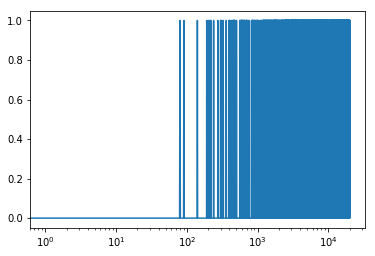

In [6]:
plt.xscale("log")
plt.plot(reward_list)

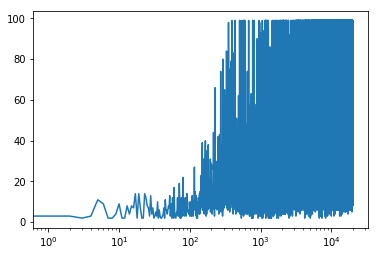

In [7]:
plt.xscale("log")
plt.plot(episode_list)